### Extraccion de Datos

In [11]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from binance.client import Client
import ta
import logging
import locale
import re
import requests  # Ensure the requests module is explicitly imported

def clean_numeric_string(value, column_name='unknown'):
    """Clean and convert numeric strings with enhanced error handling"""
    try:
        # Skip problematic array strings silently
        if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
            if set(value.strip('[]').replace(',', '').strip()).issubset({'0', "'", '"', ' '}):
                return 0.0

        # If already numeric, return as is
        if isinstance(value, (int, float)):
            return float(value)

        # If None or NaN, return NaN
        if pd.isna(value):
            return np.nan

        # Convert to string and clean
        value = str(value)

        # Handle array string format
        if value.startswith('[') and value.endswith(']'):
            try:
                value = value.strip('[]').split(',')[0].strip("' ")
            except:
                return np.nan

        # If it's all zeros after cleaning
        if set(value.strip("[]' ")).issubset({'0'}):
            return 0.0

        # Clean the string
        cleaned = ''.join(c for c in value if c.isdigit() or c in '.-')

        # If nothing valid remains after cleaning
        if not cleaned or cleaned in {'.', '-'}:
            return np.nan

        # Handle multiple decimal points
        if cleaned.count('.') > 1:
            parts = cleaned.split('.')
            cleaned = parts[0] + '.' + ''.join(parts[1:])

        try:
            result = float(cleaned)
            if abs(result) > 1e20:
                return np.nan
            return result
        except:
            return np.nan

    except:
        return np.nan

class CompleteTradingSystem:
    def __init__(self, api_key: str, api_secret: str):
        self.client = Client(api_key, api_secret)
        self.setup_logging()
        locale.setlocale(locale.LC_NUMERIC, 'C')
        pd.set_option('display.float_format', '{:.8f}'.format)

    def setup_logging(self):
        logging.basicConfig(
            level=logging.WARNING,  # Changed to WARNING to reduce output
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

    def preprocess_candle_data(self, candles):
        """Preprocess raw candle data before creating DataFrame"""
        processed_candles = []
        for candle in candles:
            try:
                processed_row = []
                for i, value in enumerate(candle):
                    if i == 0:  # timestamp
                        processed_row.append(value)
                        continue

                    if isinstance(value, str) and value.startswith('['):
                        try:
                            cleaned = value.strip('[]').split(',')[0].strip()
                            if set(cleaned.strip("' ")).issubset({'0'}):
                                processed_row.append('0')
                            else:
                                processed_row.append(cleaned)
                        except:
                            processed_row.append('0')
                    else:
                        processed_row.append(value)

                processed_candles.append(processed_row)
            except:
                continue
        return processed_candles

    def fetch_historical_data(self, symbol: str, interval: str = '1h', lookback_days: int = 730) -> pd.DataFrame:
        try:
            start_time = int(
                (datetime.now() - timedelta(days=lookback_days)).timestamp() * 1000
            )

            logging.info(f"Fetching historical data for {symbol}...")
            candles = self.client.get_historical_klines(
                symbol=symbol,
                interval=interval,
                start_str=start_time
            )

            if not candles:
                return pd.DataFrame()

            # Preprocess and create DataFrame
            processed_candles = self.preprocess_candle_data(candles)

            columns = [
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades', 'taker_buy_base',
                'taker_buy_quote', 'ignore'
            ]

            df = pd.DataFrame(processed_candles, columns=columns)

            # Convert timestamp
            df['timestamp'] = pd.to_datetime(df['timestamp'].astype(float), unit='ms')
            df.set_index('timestamp', inplace=True)

            # Convert numeric columns silently
            numeric_columns = ['open', 'high', 'low', 'close', 'volume',
                             'quote_volume', 'trades', 'taker_buy_base',
                             'taker_buy_quote']

            for col in numeric_columns:
                df[col] = df[col].apply(lambda x: clean_numeric_string(x, col))

            # Remove any rows with invalid data
            df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

            if not df.empty:
                df = self.add_technical_indicators(df)

            return df

        except Exception as e:
            logging.error(f"Error fetching data for {symbol}: {str(e)}")
            return pd.DataFrame()

    def add_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add technical indicators to the DataFrame"""
        try:
            df = df.copy()

            # Trend Indicators
            df['sma_20'] = ta.trend.sma_indicator(df['close'], window=20)
            df['sma_50'] = ta.trend.sma_indicator(df['close'], window=50)
            df['sma_200'] = ta.trend.sma_indicator(df['close'], window=200)
            df['ema_20'] = ta.trend.ema_indicator(df['close'], window=20)
            df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'])

            # MACD
            macd = ta.trend.MACD(df['close'])
            df['macd'] = macd.macd()
            df['macd_signal'] = macd.macd_signal()
            df['macd_diff'] = macd.macd_diff()

            # Momentum Indicators
            df['rsi'] = ta.momentum.rsi(df['close'])
            stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'])
            df['stoch_k'] = stoch.stoch()
            df['stoch_d'] = stoch.stoch_signal()
            df['cci'] = ta.trend.cci(df['high'], df['low'], df['close'])
            df['williams_r'] = ta.momentum.williams_r(df['high'], df['low'], df['close'])

            # Volatility Indicators
            df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])
            bollinger = ta.volatility.BollingerBands(df['close'])
            df['bollinger_high'] = bollinger.bollinger_hband()
            df['bollinger_low'] = bollinger.bollinger_lband()
            df['bollinger_mid'] = bollinger.bollinger_mavg()
            df['bollinger_bandwidth'] = (df['bollinger_high'] - df['bollinger_low']) / df['bollinger_mid']

            # Volume Indicators
            df['obv'] = ta.volume.on_balance_volume(df['close'], df['volume'])
            df['mfi'] = ta.volume.money_flow_index(df['high'], df['low'], df['close'], df['volume'], window=14)
            df['vwap'] = (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()

            # Custom Calculations
            df['returns'] = df['close'].pct_change()
            df['volatility'] = df['returns'].rolling(window=20).std()
            df['z_score'] = (df['close'] - df['sma_20']) / df['atr']
            df['momentum'] = df['close'] - df['close'].shift(10)
            df['daily_range'] = df['high'] - df['low']
            df['daily_return'] = df['close'].pct_change()
            df['cumulative_return'] = (1 + df['daily_return']).cumprod()

            return df.dropna()

        except Exception as e:
            logging.error(f"Error adding indicators: {str(e)}")
            return df

    def fetch_historical_data(self, symbol: str, interval: str = '1h', lookback_days: int = 730) -> pd.DataFrame:
        try:
            start_time = int((datetime.now() - timedelta(days=lookback_days)).timestamp() * 1000)
            logging.info(f"Fetching historical data for {symbol}...")
            candles = self.client.get_historical_klines(symbol=symbol, interval=interval, start_str=start_time)
            if not candles:
                return pd.DataFrame()
            processed_candles = self.preprocess_candle_data(candles)
            columns = [
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades', 'taker_buy_base',
                'taker_buy_quote', 'ignore'
            ]
            df = pd.DataFrame(processed_candles, columns=columns)
            df['timestamp'] = pd.to_datetime(df['timestamp'].astype(float), unit='ms')
            df.set_index('timestamp', inplace=True)
            numeric_columns = ['open', 'high', 'low', 'close', 'volume',
                               'quote_volume', 'trades', 'taker_buy_base',
                               'taker_buy_quote']
            for col in numeric_columns:
                df[col] = df[col].apply(lambda x: clean_numeric_string(x, col))
            df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])
            if not df.empty:
                df = self.add_technical_indicators(df)
                df['btc_dominance'] = self.fetch_btc_dominance(df)
                df = self.add_dominance_indicators(df)
            return df
        except Exception as e:
            logging.error(f"Error fetching data for {symbol}: {str(e)}")
            return pd.DataFrame()
        

    def add_dominance_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        try:
            df['btc_dom_sma20'] = ta.trend.sma_indicator(df['btc_dominance'], window=20)
            df['btc_dom_sma50'] = ta.trend.sma_indicator(df['btc_dominance'], window=50)
            df['btc_dom_rsi'] = ta.momentum.rsi(df['btc_dominance'])
            df['btc_dom_macd'] = ta.trend.macd_diff(df['btc_dominance'])
            df['btc_dom_volatility'] = df['btc_dominance'].pct_change().rolling(window=20).std()
            df['btc_dom_trend'] = df['btc_dominance'].diff()
            df['btc_dom_trend_strength'] = abs(df['btc_dom_trend'])
            
            # Correlation with price
            df['price_dom_corr'] = df['close'].rolling(window=20).corr(df['btc_dominance'])
            
            return df
        except Exception as e:
            self.logger.error(f"Error adding dominance indicators: {str(e)}")
            return df

    def get_indicator_groups(self) -> dict:
        return {
            'Price': ['open', 'high', 'low', 'close', 'volume'],
            'Trend': ['sma_20', 'sma_50', 'sma_200', 'ema_20', 'adx', 'macd', 'macd_signal', 'macd_diff'],
            'Momentum': ['rsi', 'stoch_k', 'stoch_d', 'cci', 'williams_r'],
            'Volatility': ['atr', 'bollinger_high', 'bollinger_low', 'bollinger_mid', 'bollinger_bandwidth'],
            'Volume': ['obv', 'mfi', 'vwap'],
            'Custom': ['returns', 'volatility', 'z_score', 'momentum', 'daily_range', 'daily_return', 'cumulative_return'],
            'Dominance': ['btc_dominance', 'btc_dom_sma20', 'btc_dom_sma50', 'btc_dom_rsi', 'btc_dom_macd', 
                         'btc_dom_volatility', 'btc_dom_trend', 'btc_dom_trend_strength', 'price_dom_corr']
        }

def test_system():
    try:
        api_key = 'TQS64xqW4DsSgXraf3Bfda0lsrbbJopaL8vxQKK2MDbiSzjrFYdZK32GTn59XDdv'
        api_secret = 'JA1laXjaDYdgQOxWFaIxkRmynFxFLfVVy9GWHho8CCYyj7cY3GbpoFFZfmwUACO2'

        print("Initializing system...")
        trading_system = CompleteTradingSystem(api_key, api_secret)

        symbols = ['BTCUSDT', 'SOLUSDT', 'ALGOUSDT']
        interval = '1h'
        lookback_days = 730

        data_frames = {}

        for symbol in symbols:
            print(f"Processing {symbol} data...")
            df = trading_system.fetch_historical_data(symbol, interval, lookback_days)

            if not df.empty:
                # Clean data before export
                df = df.replace([np.inf, -np.inf], np.nan).dropna()

                # Export main analysis
                filename = f"{symbol}_1h_2years.csv"
                df.to_csv(filename,
                         sep=';',
                         decimal='.',
                         float_format=lambda x: '{:.8f}'.format(x) if not pd.isna(x) else '',
                         encoding='utf-8')
                print(f"Analysis saved: {filename}")

        return True

    except Exception as e:
        logging.error(f"Error in test_system: {str(e)}")
        return False

if __name__ == "__main__":
    print("Starting Trading System")
    print("======================")
    if test_system():
        print("Process completed successfully")
    else:
        print("Process completed with some data excluded")


Starting Trading System
Initializing system...


2024-12-30 10:55:39,836 - INFO - Fetching historical data for BTCUSDT...


Processing BTCUSDT data...


2024-12-30 10:56:00,081 - INFO - Fetching historical data for SOLUSDT...


Analysis saved: BTCUSDT_1h_2years.csv
Processing SOLUSDT data...


2024-12-30 10:56:17,103 - INFO - Fetching historical data for ALGOUSDT...


Analysis saved: SOLUSDT_1h_2years.csv
Processing ALGOUSDT data...
Analysis saved: ALGOUSDT_1h_2years.csv
Process completed successfully


In [3]:
import websocket
import json
import time
import pandas as pd
from datetime import datetime

class TradingViewBTCDominanceFetcher:
    def __init__(self, symbol="CRYPTOCAP:BTC.D", interval="D"):
        self.ws_url = "wss://data.tradingview.com/socket.io/websocket"
        self.symbol = symbol
        self.interval = interval
        self.session_id = self.generate_session()
        self.chart_session = self.generate_session("cs_")
        self.data = []
        self.connected = False

    def generate_session(self, prefix="qs_"):
        """Generate a random session ID."""
        import random
        import string
        session = "".join(random.choice(string.ascii_lowercase) for _ in range(12))
        return prefix + session

    def send_message(self, ws, func, args):
        """Send a JSON-formatted message to the WebSocket."""
        payload = json.dumps({"m": func, "p": args}, separators=(",", ":"))
        ws.send(f"~m~{len(payload)}~m~{payload}")

    def on_message(self, ws, message):
        """Handle incoming messages from WebSocket."""
        try:
            # Ignore heartbeat messages (~h~)
            if message.startswith("~m~"):
                if "~h~" in message:
                    return  # Ignore heartbeat messages
                # Extract JSON part of the message
                parts = message.split("~m~")
                if len(parts) > 2:
                    json_part = parts[2]
                    response = json.loads(json_part)
                    
                    # Handle timescale update (historical data)
                    if response.get("m") == "timescale_update":
                        self.process_data(response["p"][1]["s"])
                    
                    # Handle real-time updates (qsd messages)
                    elif response.get("m") == "qsd":
                        update = response["p"][1]
                        print(f"Real-time update: {update}")
                        # Optionally, store updates to analyze real-time data
                    
                    # Handle symbol error
                    elif response.get("m") == "symbol_error":
                        print("Symbol resolution failed. Check the symbol name.")
                    
                    else:
                        print(f"Unhandled message: {response}")
            else:
                print(f"Non-JSON message received: {message}")
        except json.JSONDecodeError as e:
            print(f"JSON decoding error: {e}, message: {message}")
        except Exception as e:
            print(f"Error processing message: {e}, raw message: {message}")



    def process_data(self, data):
        """Process received historical data."""
        for bar in data["s"]:
            self.data.append({
                "timestamp": datetime.utcfromtimestamp(bar[0]),
                "open": bar[1],
                "high": bar[2],
                "low": bar[3],
                "close": bar[4],
                "volume": bar[5] if len(bar) > 5 else None,
            })

    def on_open(self, ws):
        """Actions to perform when WebSocket is opened."""
        self.connected = True
        self.send_message(ws, "quote_create_session", [self.session_id])
        self.send_message(ws, "quote_add_symbols", [self.session_id, self.symbol])
        self.send_message(ws, "chart_create_session", [self.chart_session])
        self.send_message(ws, "resolve_symbol", [self.chart_session, "symbol_1", f'={self.symbol}'])
        self.send_message(ws, "create_series", [
            self.chart_session, "s1", "s1", "symbol_1", self.interval, 300
        ])

    def on_close(self, ws, close_status_code, close_msg):
        """Actions to perform when WebSocket is closed."""
        print("WebSocket closed")
        self.connected = False

    def fetch_data(self):
        """Connect to WebSocket and fetch data."""
        ws = websocket.WebSocketApp(
            self.ws_url,
            on_open=self.on_open,
            on_message=self.on_message,
            on_close=self.on_close,
        )
        ws.run_forever()
        while self.connected:
            time.sleep(1)

    def save_to_csv(self, filename="btc_dominance_data.csv"):
        """Save collected data to a CSV file."""
        if self.data:
            df = pd.DataFrame(self.data)
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")
        else:
            print("No data to save")

# Example usage
if __name__ == "__main__":
    fetcher = TradingViewBTCDominanceFetcher(symbol="CRYPTOCAP:BTC.D", interval="D")
    fetcher.fetch_data()
    fetcher.save_to_csv("btc_dominance_data.csv")


Unhandled message: {'session_id': '0.6077.3616_dal-charts-34-webchart-9', 'timestamp': 1735599689, 'timestampMs': 1735599689319, 'release': 'release_208-11', 'studies_metadata_hash': 'e4e120c62c14578831c13e361fe7cf94178d6898', 'auth_scheme_vsn': 2, 'protocol': 'json', 'via': '209.58.146.84:443', 'javastudies': ['3.66']}
Unhandled message: {'m': 'series_loading', 'p': ['cs_ouumznkgbndr', 's1', 's1'], 't': 1735599689, 't_ms': 1735599689474}
Unhandled message: {'m': 'symbol_error', 'p': ['cs_ouumznkgbndr', 'symbol_1', 'invalid symbol'], 't': 1735599689, 't_ms': 1735599689535}
Unhandled message: {'m': 'qsd', 'p': ['qs_aunvqmfdzqsb', {'n': 'CRYPTOCAP:BTC.D', 's': 'ok', 'v': {'lp': 57.82117035277244, 'chp': -0.35, 'ch': -0.2}}]}
Unhandled message: {'m': 'qsd', 'p': ['qs_aunvqmfdzqsb', {'n': 'CRYPTOCAP:BTC.D', 's': 'ok', 'v': {'lp': 57.81088718549443, 'chp': -0.37, 'ch': -0.22}}]}
Unhandled message: {'m': 'qsd', 'p': ['qs_aunvqmfdzqsb', {'n': 'CRYPTOCAP:BTC.D', 's': 'ok', 'v': {'lp': 57.81026

In [39]:
!pip install ccxt

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
   ---------------------------------------- 5.6/5.6 MB 42.7 MB/s eta 0:00:00


### EXPLORACION DE LOS DATOS

In [4]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [49]:
# Cell 1: Imports and Class Definition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import probplot, normaltest
import logging
from typing import Dict, List, Tuple, Optional
import ta
from dataclasses import dataclass

@dataclass
class MarketInsight:
    category: str
    observation: str
    impact: str
    recommendation: str
    confidence: float  # 0-1 score
    details: Optional[Dict] = None



In [50]:
# Cell 4: Visualization Methods
class EnhancedCryptoMarketAnalyzer(EnhancedCryptoMarketAnalyzer):
    def generate_visual_analysis(self):
        """Generate comprehensive visualizations with interpretations"""
        self._plot_price_analysis()
        self._plot_technical_analysis()
        self._plot_volume_analysis()
        self._plot_momentum_analysis()
        plt.tight_layout()
        plt.show()

    def _plot_price_analysis(self):
        """Visual price analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Price and moving averages
        ax = axes[0, 0]
        ax.plot(self.df.index, self.df['close'], label='Price')
        ax.plot(self.df.index, self.df['sma_20'], label='SMA 20')
        ax.plot(self.df.index, self.df['sma_50'], label='SMA 50')
        ax.set_title('Price and Moving Averages')
        ax.legend()
        
        # Return distribution
        ax = axes[0, 1]
        sns.histplot(data=self.df['daily_return'].dropna(), kde=True, ax=ax)
        ax.set_title('Return Distribution')
        
        # Volatility
        ax = axes[1, 0]
        ax.plot(self.df.index, self.df['volatility'])
        ax.set_title('Historical Volatility')
        
        # Q-Q Plot
        ax = axes[1, 1]
        probplot(self.df['daily_return'].dropna(), dist='norm', plot=ax)
        ax.set_title('Q-Q Plot of Returns')

    def _plot_technical_analysis(self):
        """Plot technical indicators"""
        fig, axes = plt.subplots(3, 1, figsize=(15, 18))
        
        # Price and Bollinger Bands
        ax = axes[0]
        ax.plot(self.df.index, self.df['close'], label='Price')
        ax.plot(self.df.index, self.df['bollinger_high'], label='Upper BB')
        ax.plot(self.df.index, self.df['bollinger_low'], label='Lower BB')
        ax.set_title('Price and Bollinger Bands')
        ax.legend()
        
        # MACD
        ax = axes[1]
        ax.plot(self.df.index, self.df['macd'], label='MACD')
        ax.plot(self.df.index, self.df['macd_signal'], label='Signal')
        ax.bar(self.df.index, self.df['macd_diff'], alpha=0.3, label='MACD Histogram')
        ax.set_title('MACD')
        ax.legend()
        
        # RSI
        ax = axes[2]
        ax.plot(self.df.index, self.df['rsi'])
        ax.axhline(y=70, color='r', linestyle='--')
        ax.axhline(y=30, color='g', linestyle='--')
        ax.set_title('RSI')

    def _plot_volume_analysis(self):
        """Plot volume analysis"""
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))
        
        # Volume and Moving Average
        ax = axes[0]
        ax.bar(self.df.index, self.df['volume'], alpha=0.3)
        ax.plot(self.df.index, self.df['volume_sma'], color='red', label='Volume SMA')
        ax.set_title('Volume Analysis')
        ax.legend()
        
        # Volume Ratio
        ax = axes[1]
        ax.plot(self.df.index, self.df['volume_ratio'])
        ax.axhline(y=1, color='k', linestyle='--')
        ax.set_title('Volume Ratio')

    def _plot_momentum_analysis(self):
        """Plot momentum indicators"""
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))
        
        # Stochastic
        ax = axes[0]
        ax.plot(self.df.index, self.df['stoch_k'], label='Stoch %K')
        ax.plot(self.df.index, self.df['stoch_d'], label='Stoch %D')
        ax.axhline(y=80, color='r', linestyle='--')
        ax.axhline(y=20, color='g', linestyle='--')
        ax.set_title('Stochastic Oscillator')
        ax.legend()
        
        # CCI
        ax = axes[1]
        ax.plot(self.df.index, self.df['cci'])
        ax.axhline(y=100, color='r', linestyle='--')
        ax.axhline(y=-100, color='g', linestyle='--')
        ax.set_title('CCI')

In [22]:
import csv
import json
import time
from datetime import datetime

import requests

#gets data from coingecko
response = requests.get('https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page=250&page=1&sparkline=false')
response = response.json()

#initialises variables
BTCCap = 0
altCap = 0
current_time = datetime.now().strftime("%d-%m-%Y")
#current_time = datetime.now().strftime("%d-%m-%Y %H:%M:%S")


#iterates through response
for x in response:
    #print(x['id'])
    if x['id'] == "bitcoin": #adds bitcoin market cap to BTCCap and altCap
        BTCCap = x['market_cap']
        altCap = altCap + x['market_cap']
    else: #adds any altcoin market cap to altCap
        altCap = altCap + x['market_cap']
        
with open("BTCDominance.csv", mode='a+', newline ="") as datawriter: #writes the data to a CSV BTCDominance, will generate the file if it does not exist.
    datawriter = csv.writer(datawriter, delimiter=",")
    datawriter.writerow([current_time,"{:.2f}".format((BTCCap/altCap)*100)]) #writes bitcoin dominance out of 100 to 2dp

NameError: name 'EnhancedCryptoMarketAnalyzer' is not defined

In [54]:
# Cell 7: Instance Creation and Analysis
# Create analyzer instance
analyzer = EnhancedCryptoMarketAnalyzer('ALGOUSDT_1h_2years.csv', 'ALGOUSDT')

# Generate market report
market_report = analyzer.generate_market_report()

# Display results
print("=== Market Regime Analysis ===")
print("\nTrend Analysis:")
print(market_report['market_regime']['trend'])



C:\Users\pedro\AppData\Local\Temp\ipykernel_62696\45480378.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['volume'] = df['volume'].fillna(method='ffill')
2024-12-24 15:41:59,455 - ERROR - Error in basic statistics: 'dict' object has no attribute 'skew'


=== Market Regime Analysis ===

Trend Analysis:
{'short_term': 'bullish', 'medium_term': 'bullish', 'long_term': 'bullish', 'strength': 31.366934153200948, 'macd_signal': 'bullish'}


In [55]:
print("\nVolatility Analysis:")
print(market_report['market_regime']['volatility'])




Volatility Analysis:
{'current_volatility': 0.2853374565386904, 'historical_volatility': 0.13437350239130624, 'relative_volatility': 2.1234652030410373, 'bollinger_width': 0.14231933666566948, 'regime': 'high'}


In [56]:
print("\nMomentum Analysis:")
print(market_report['market_regime']['momentum'])




Momentum Analysis:
{'rsi': 61.63924339245577, 'stoch_k': 63.333333333333314, 'stoch_d': 62.916666666666835, 'cci': 76.69732869411712, 'williams_r': -36.666666666666686}


In [57]:
print("\nRisk Metrics:")
for key, value in market_report['risk_metrics'].items():
    print(f"{key}: {value:.4f}")




Risk Metrics:
value_at_risk_95: -0.0142
conditional_var_95: -0.0239
annual_volatility: 0.1581
max_drawdown: -0.7028
sharpe_ratio: -0.0543
sortino_ratio: -0.0684


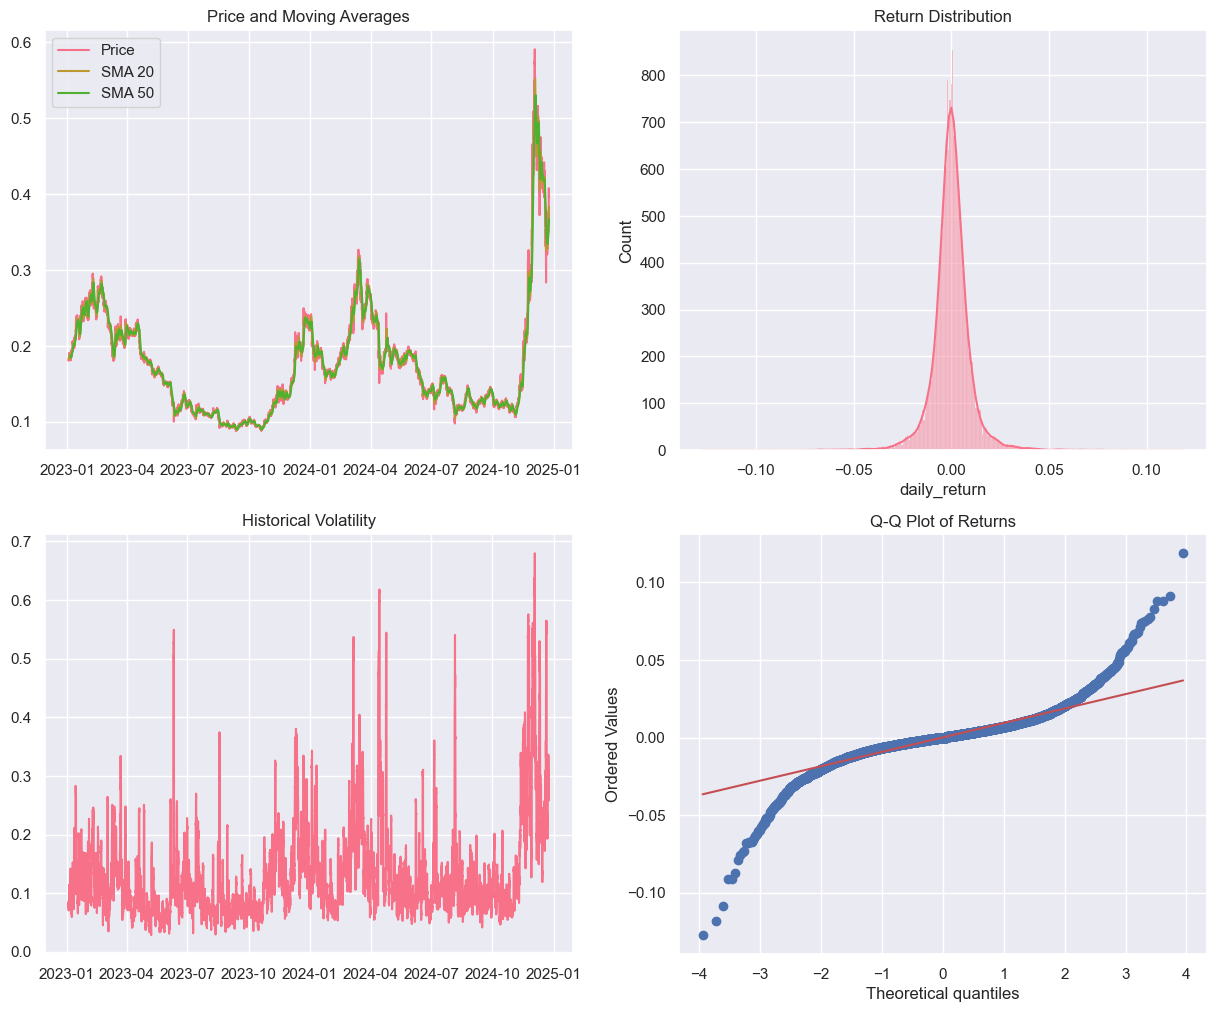

In [59]:
# Generate visualizations
analyzer._plot_price_analysis()




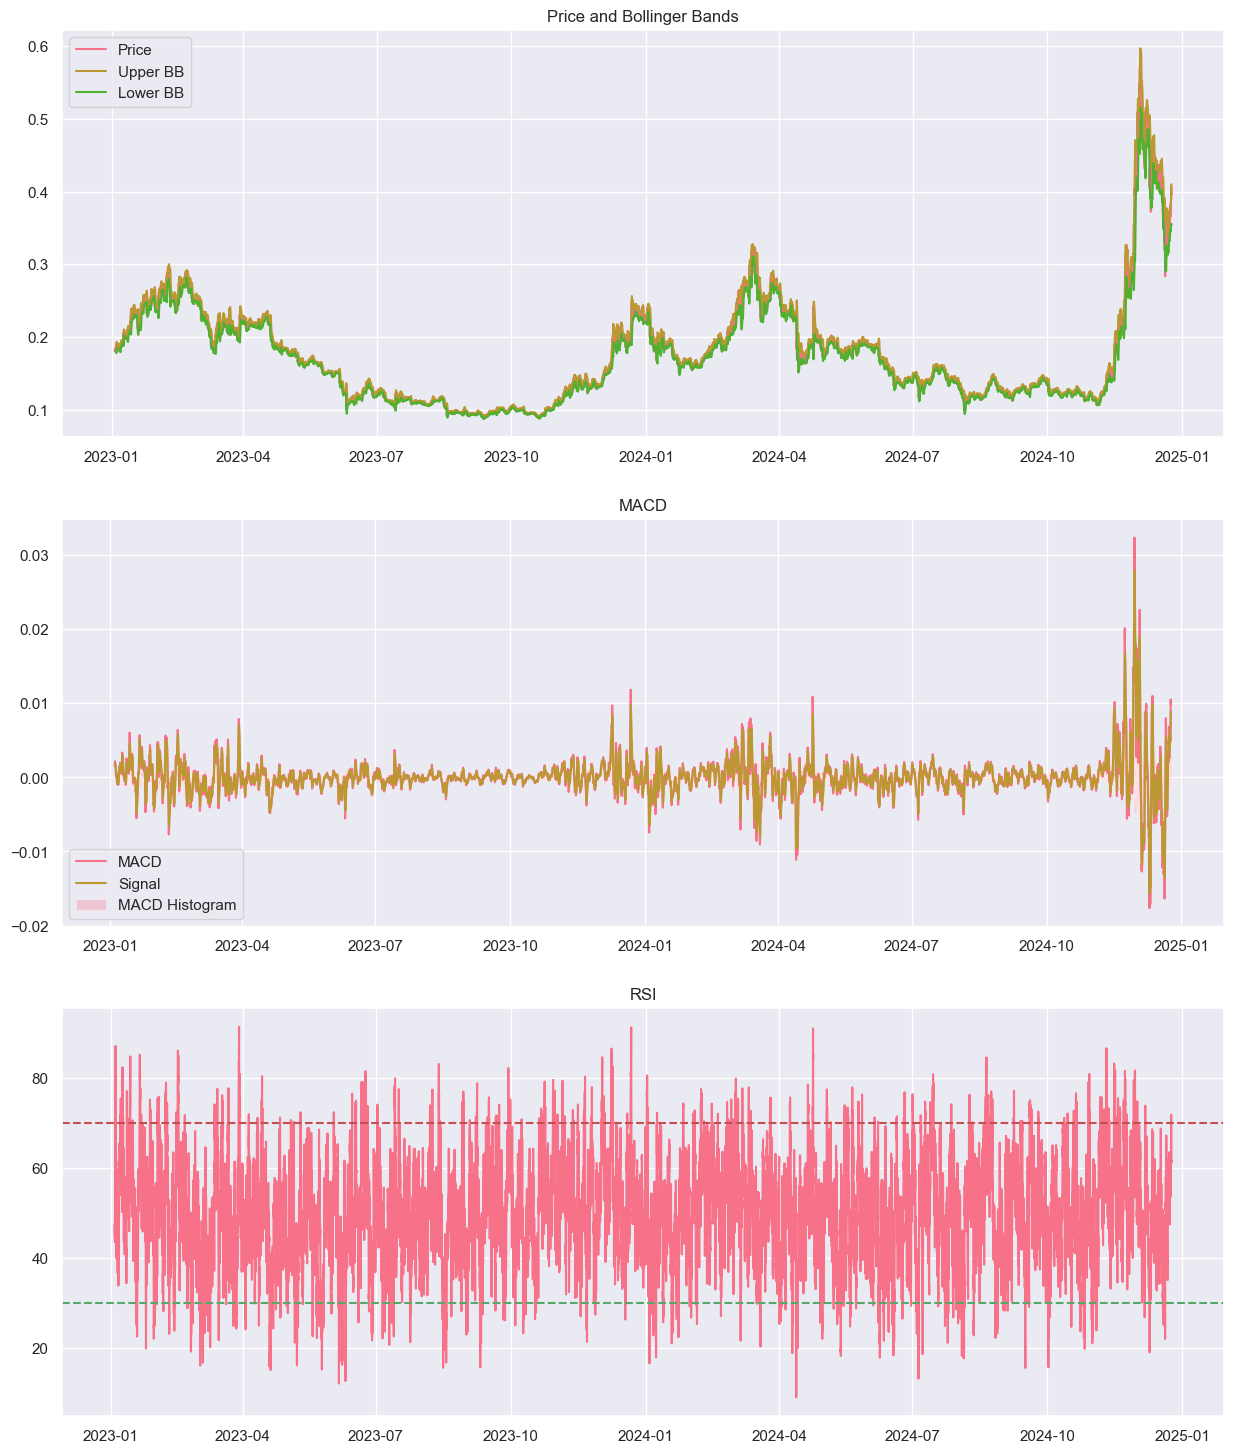

In [60]:
analyzer._plot_technical_analysis()

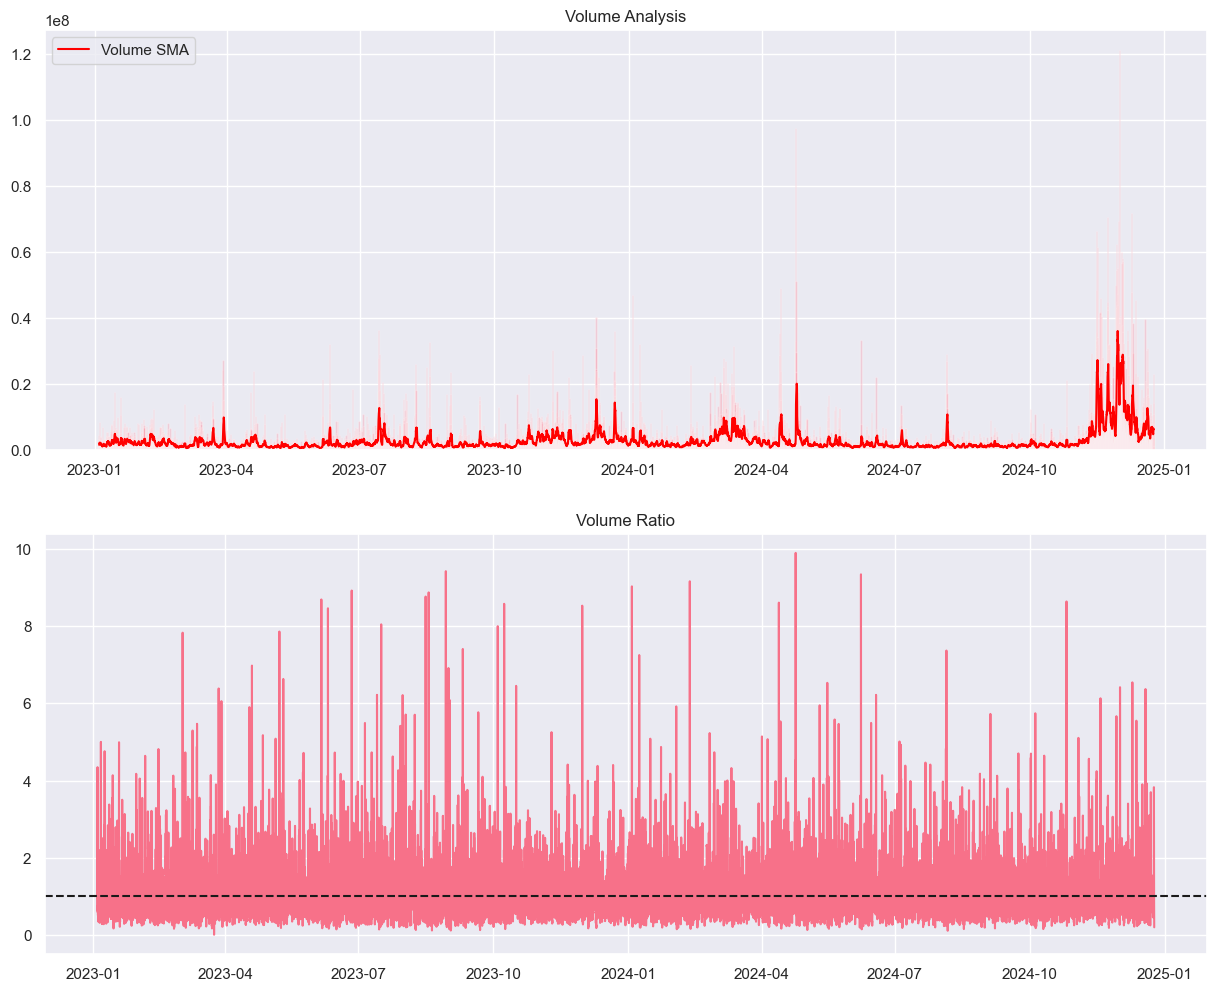

In [61]:
analyzer._plot_volume_analysis()

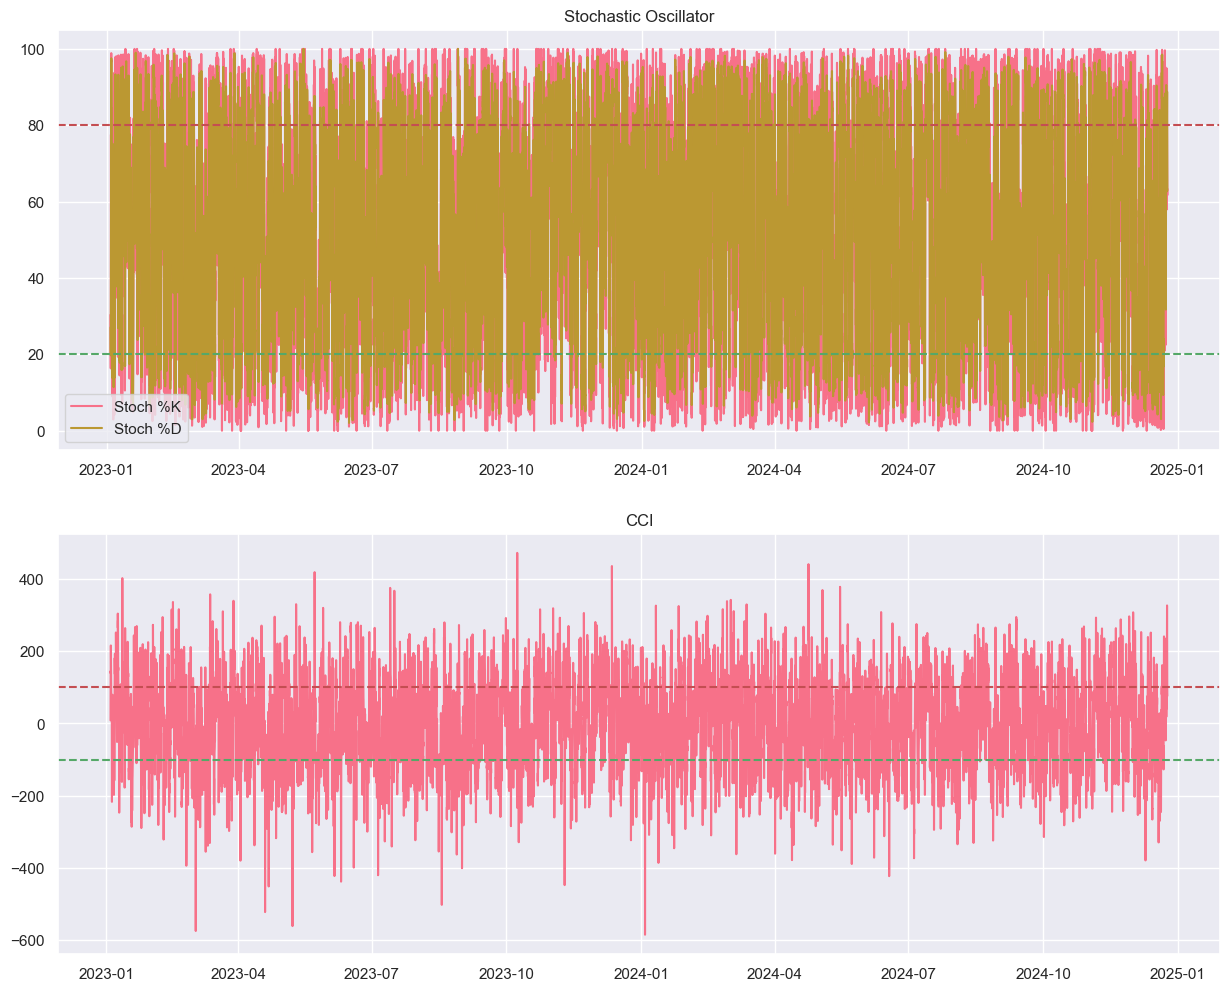

In [62]:
analyzer._plot_momentum_analysis()

In [76]:
# Cell 1: Crear instancia del analizador
analyzer = EnhancedCryptoMarketAnalyzer('ALGOUSDT_1h_2years.csv', 'ALGOUSDT')



C:\Users\pedro\AppData\Local\Temp\ipykernel_62696\45480378.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['volume'] = df['volume'].fillna(method='ffill')


In [77]:
# Cell 2: Calcular matriz de correlaciones primero
correlation_features = [
    'close', 'volume', 'daily_return', 'volatility',
    'rsi', 'macd', 'cci', 'williams_r', 'stoch_k'
]
corr_matrix = analyzer.df[correlation_features].corr()



In [79]:
# Cell 3: Interpretar correlaciones
insights = analyzer._interpret_correlations(corr_matrix)
print("\nCorrelation Insights:")
for insight in insights:
    print(f"- {insight}")




Correlation Insights:
- Strongest price correlation is with volatility (0.50)
- Strongest volume correlation is with volatility (0.56)
- RSI shows strongest correlation with cci (0.86)
- MACD shows strongest correlation with rsi (0.60)
- CCI shows strongest correlation with rsi (0.86)


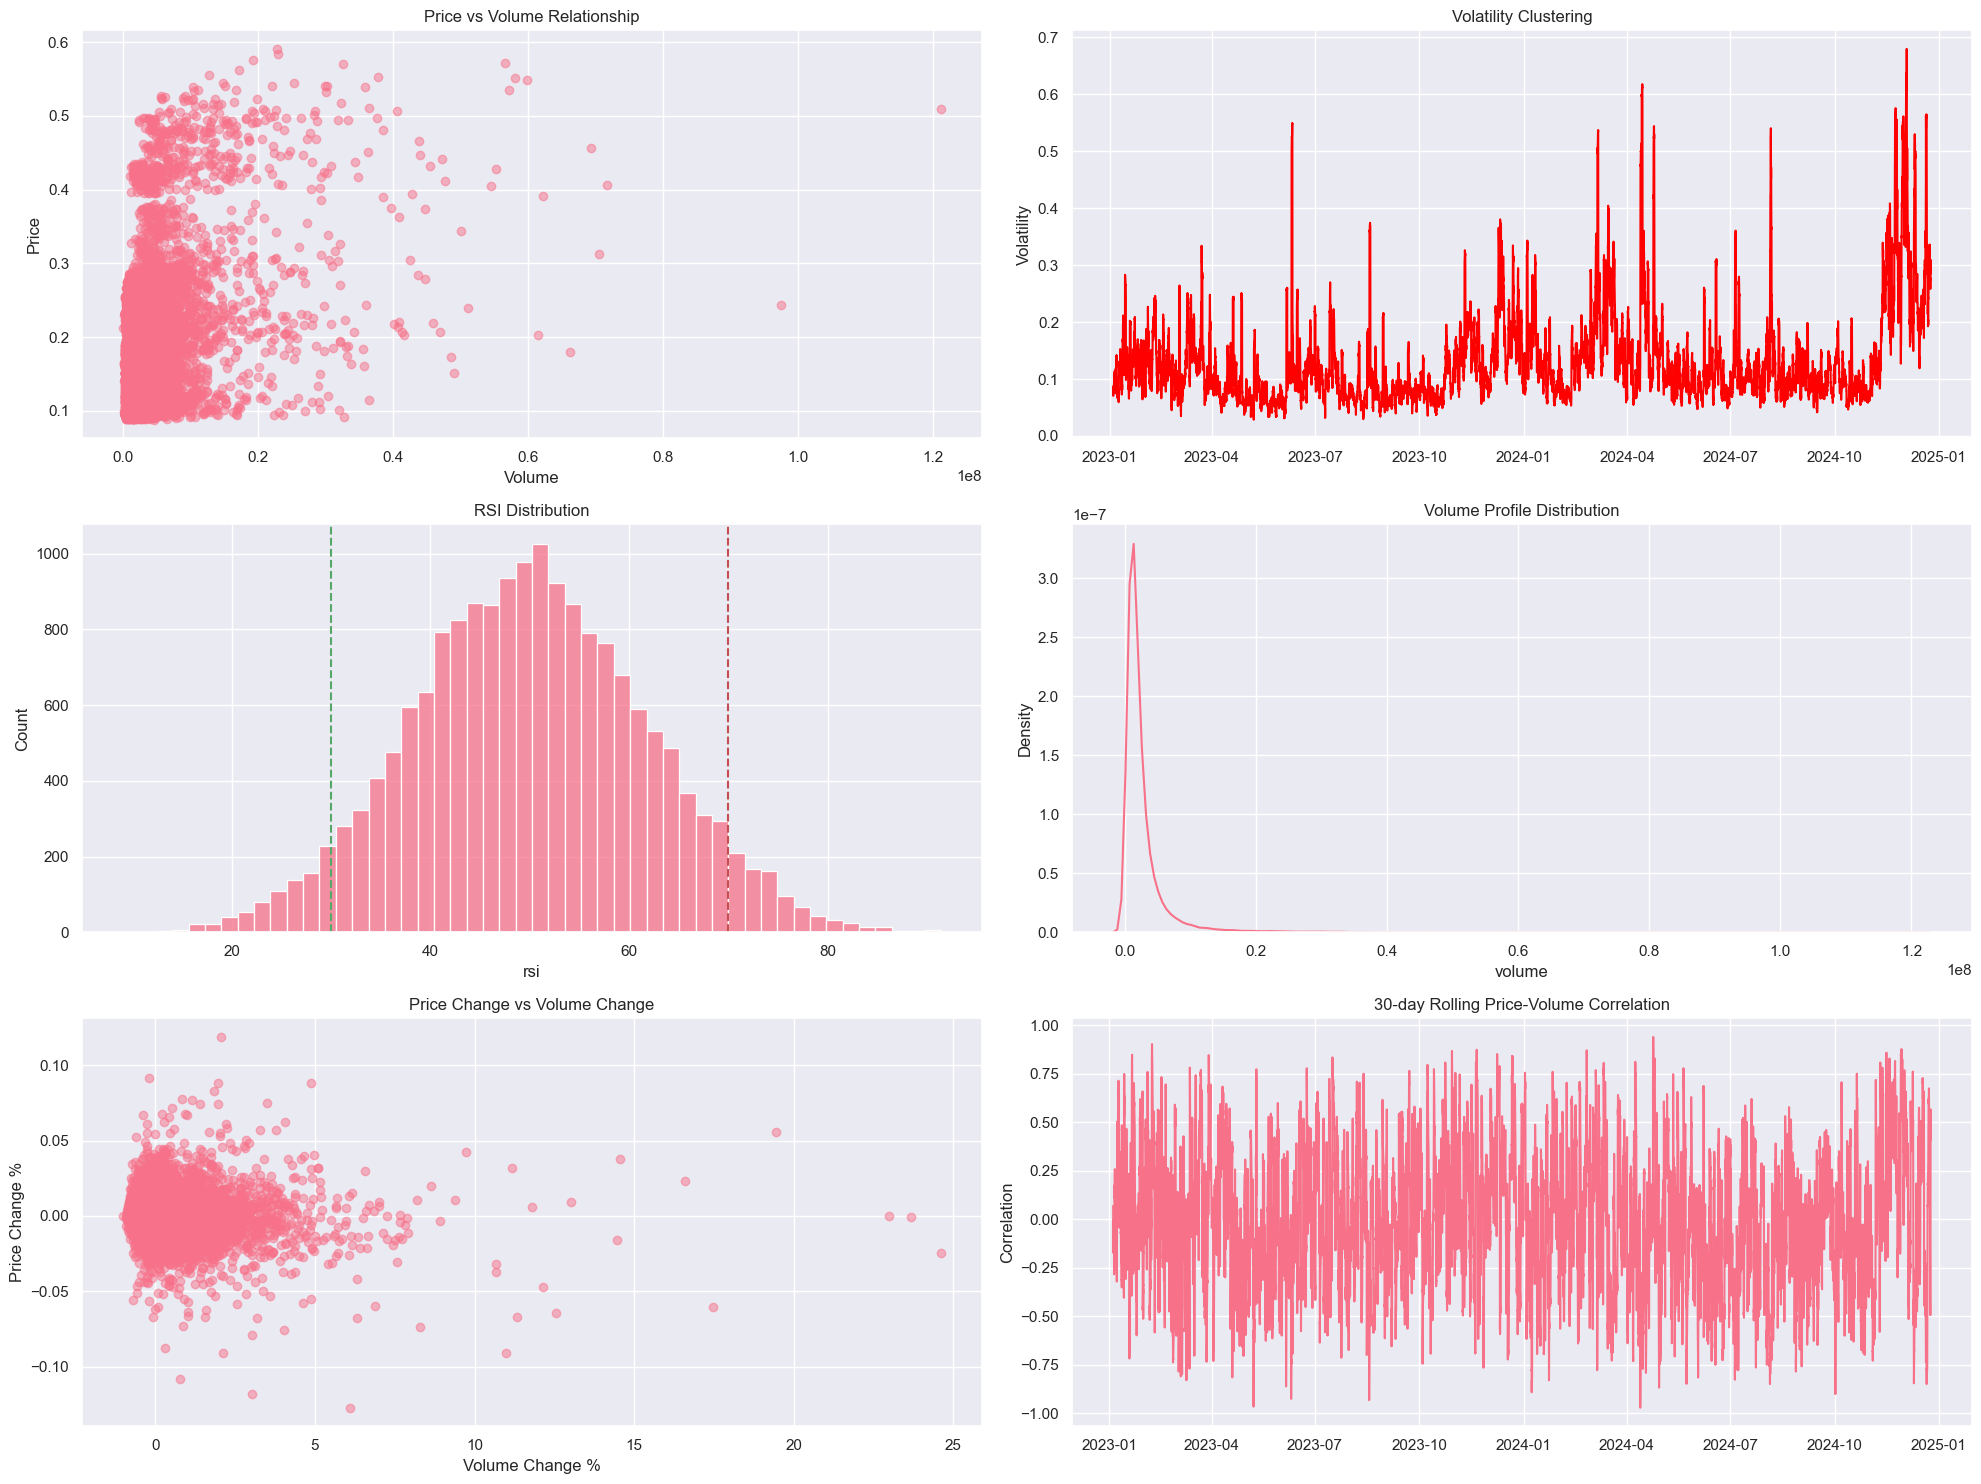

In [80]:
# Cell 4: Visualizar patrones
analyzer._plot_pattern_analysis()



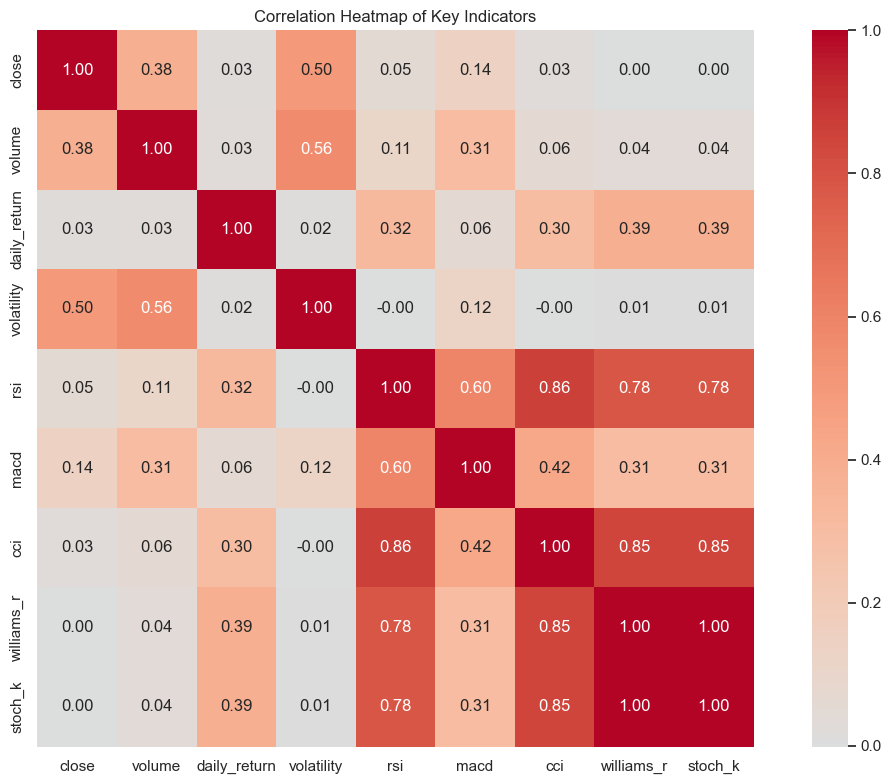

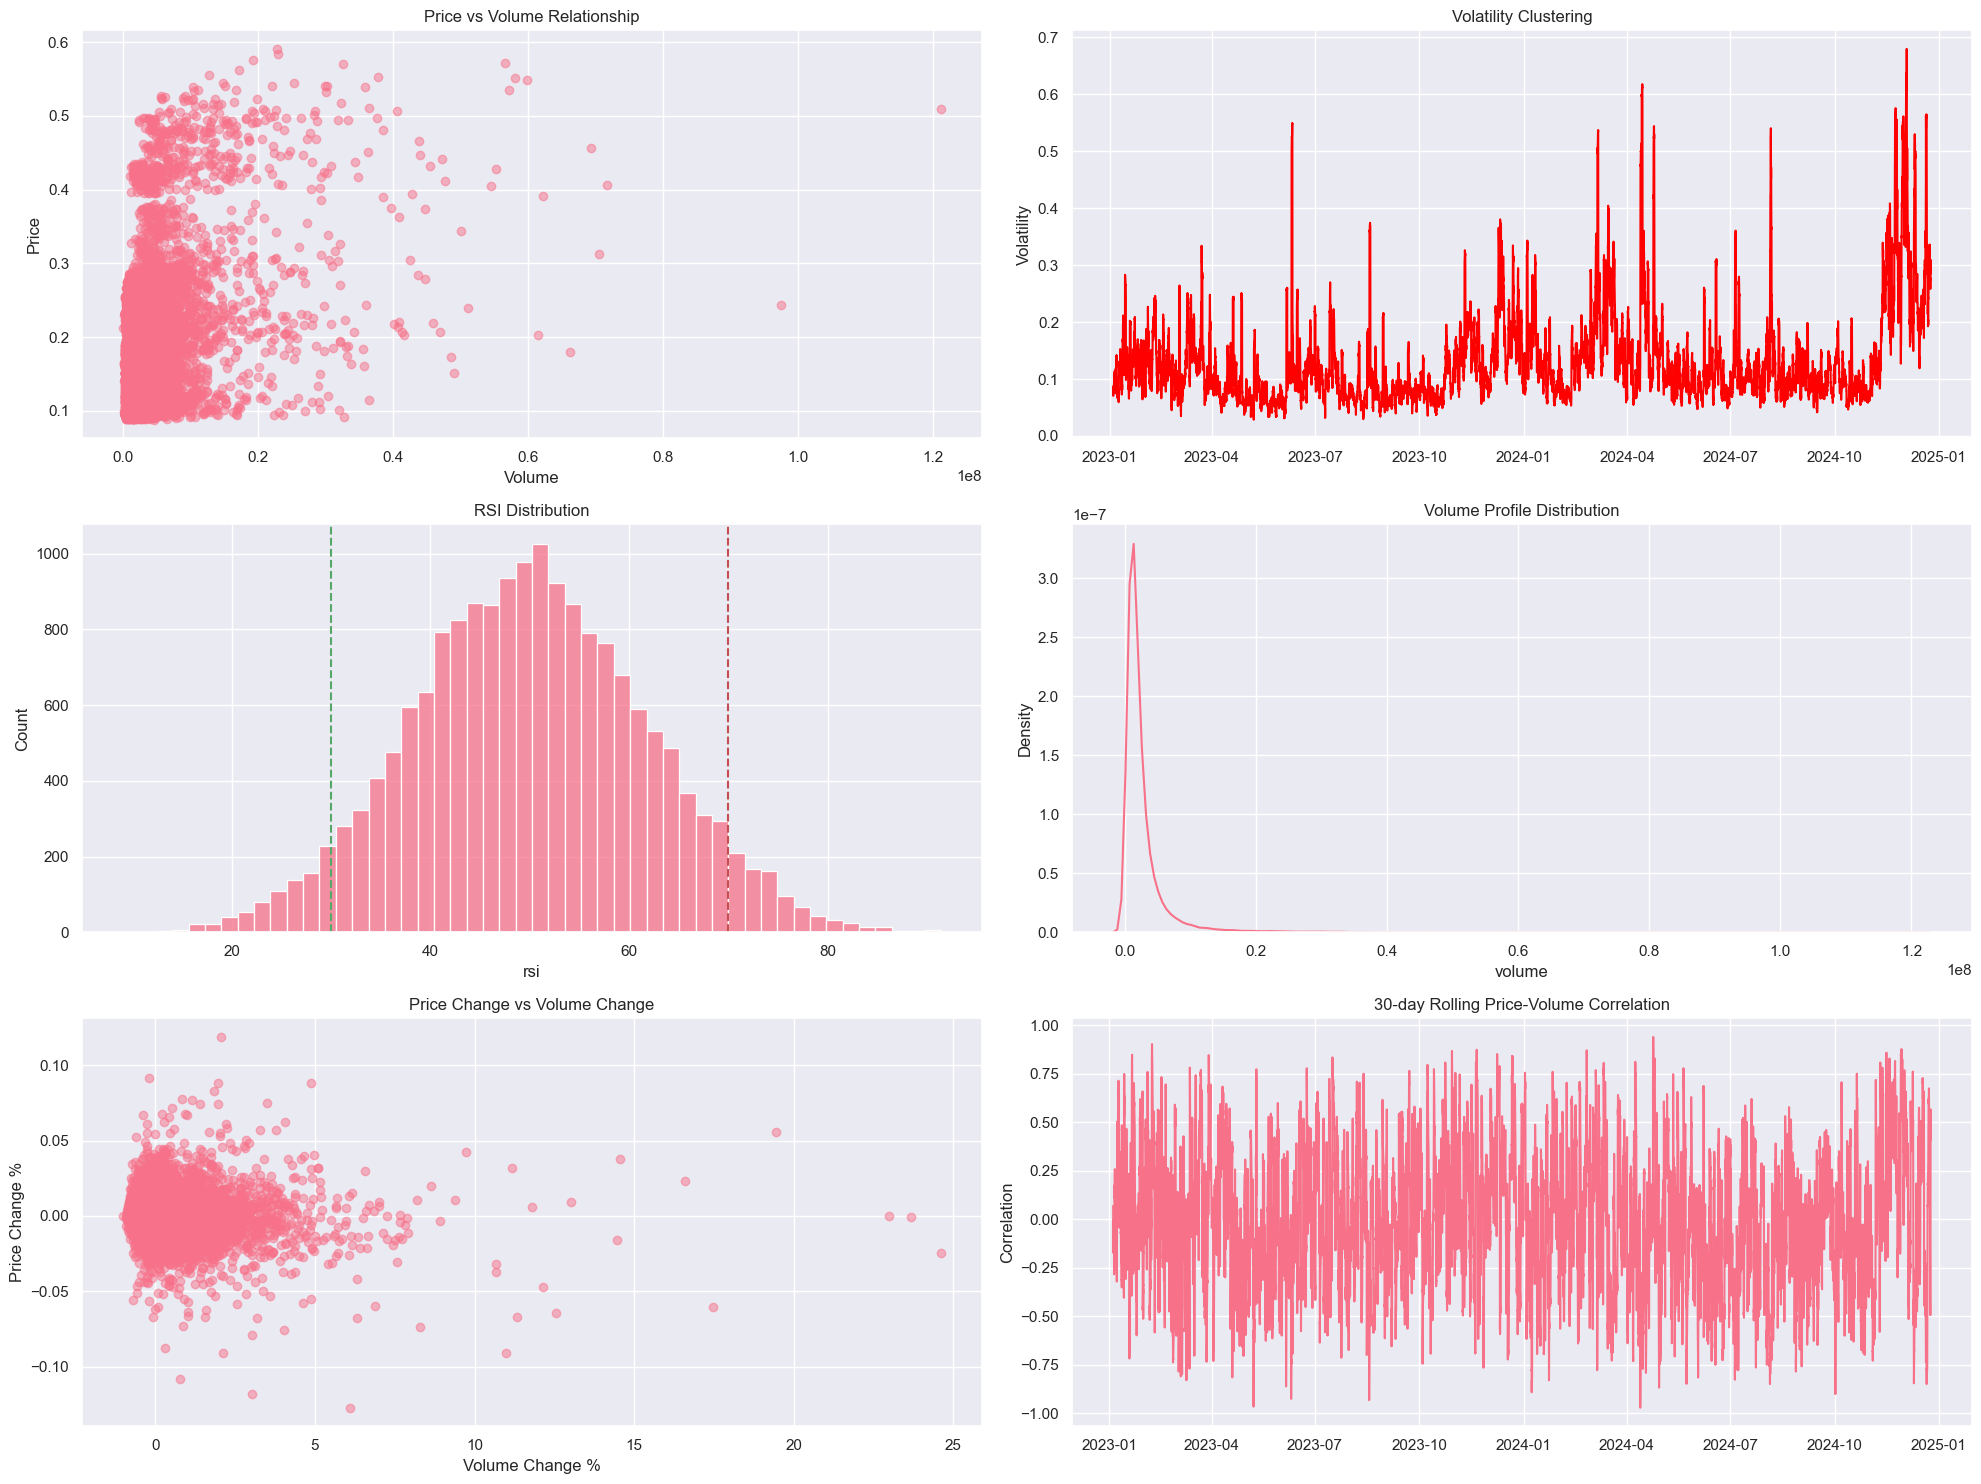

In [81]:
# Cell 5: Análisis completo de correlaciones y patrones
full_analysis = analyzer.analyze_correlations_and_patterns()

### HMM Test

In [113]:
# Cell 1: Imports y definiciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import probplot, normaltest
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from arch import arch_model
import logging
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass, field
import ta
import json
from pathlib import Path

@dataclass
class MarketInsight:
    category: str
    observation: str
    impact: str
    recommendation: str
    confidence: float
    details: Optional[Dict] = None

@dataclass
class ModelConfig:
    n_components: int = 7
    covariance_type: str = "full"
    n_iter: int = 1000
    random_state: int = 42
    train_test_split: float = 0.2
    volatility_window: int = 24
    state_names: Dict[int, str] = field(default_factory=lambda: {
        0: "Bullish Trending",
        1: "Bearish Trending",
        2: "Sideways Consolidation",
        3: "Upward Consolidation",
        4: "Downward Consolidation",
        5: "Downward Capitulation",
        6: "Upward Capitulation"
    })
    features: List[str] = field(default_factory=lambda: ['Returns', 'Volatility', 'Volume_Change'])

class EnhancedCryptoAnalyzer:
    def __init__(self, csv_path: str, symbol: str = 'ALGOUSDT'):
        self.setup_logging()
        self.symbol = symbol
        self.config = ModelConfig()
        self.df = self._load_and_prepare_data(csv_path)
        self.setup_visualization()
        self.model = None
        self.scaler = None
        self.states = None
        self.metrics = {}

    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def setup_visualization(self):
        plt.style.use('default')
        sns.set_theme(style="darkgrid")
        sns.set_palette("husl")
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.rcParams['font.size'] = 12

    def _load_and_prepare_data(self, csv_path: str) -> pd.DataFrame:
        try:
            try:
                df = pd.read_csv(csv_path, sep=';', decimal='.', parse_dates=['timestamp'])
            except:
                df = pd.read_csv(csv_path, decimal='.', parse_dates=['timestamp'])
            
            df.set_index('timestamp', inplace=True)
            
            # Validar y limpiar datos
            epsilon = 1e-8
            df['close'] = df['close'].replace(0, epsilon)
            df['volume'] = df['volume'].replace(0, 1)
            
            df = self._add_technical_indicators(df)
            df = self._add_derived_features(df)
            
            # Indicadores HMM con manejo de infinitos
            df['Returns'] = df['close'].pct_change().replace([np.inf, -np.inf], np.nan)
            df['Log_Returns'] = np.log(df['close'] + epsilon).diff().replace([np.inf, -np.inf], np.nan)
            df['Volatility'] = df['Returns'].rolling(window=self.config.volatility_window).std()
            df['Volume_Change'] = df['volume'].pct_change().replace([np.inf, -np.inf], np.nan)
            
            # Limpiar datos extremos usando IQR
            for col in ['Returns', 'Log_Returns', 'Volatility', 'Volume_Change']:
                if col in df.columns:
                    Q1 = df[col].quantile(0.01)
                    Q3 = df[col].quantile(0.99)
                    IQR = Q3 - Q1
                    df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
            
            df = df.fillna(method='ffill').fillna(method='bfill')
            return df

        except Exception as e:
            self.logger.error(f"Error loading data: {str(e)}")
            raise

    def _add_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        try:
            df['bollinger_high'] = ta.volatility.bollinger_hband(df['close'])
            df['bollinger_low'] = ta.volatility.bollinger_lband(df['close'])
            df['bollinger_mid'] = ta.volatility.bollinger_mavg(df['close'])
            df['bollinger_bandwidth'] = (df['bollinger_high'] - df['bollinger_low']) / df['bollinger_mid']
            
            df['rsi'] = ta.momentum.rsi(df['close'])
            df['macd'] = ta.trend.macd_diff(df['close'])
            df['cci'] = ta.trend.cci(df['high'], df['low'], df['close'])
            df['williams_r'] = ta.momentum.williams_r(df['high'], df['low'], df['close'])
            
            df['volume_sma'] = df['volume'].rolling(window=20).mean()
            df['volume_ratio'] = df['volume'] / df['volume'].rolling(window=20).mean()
            
            stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'])
            df['stoch_k'] = stoch.stoch()
            df['stoch_d'] = stoch.stoch_signal()
            
            return df
        except Exception as e:
            self.logger.error(f"Error adding technical indicators: {str(e)}")
            raise

    def _add_derived_features(self, df: pd.DataFrame) -> pd.DataFrame:
        try:
            df['price_sma_short'] = df['close'].rolling(window=10).mean()
            df['price_sma_long'] = df['close'].rolling(window=30).mean()
            df['trend_strength'] = (df['price_sma_short'] - df['price_sma_long']) / df['price_sma_long']
            
            df['daily_range'] = (df['high'] - df['low']) / df['close']
            df['momentum'] = df['close'].diff(periods=10) / df['close'].shift(10)
            df['daily_return'] = df['close'].pct_change()
            df['cumulative_return'] = (1 + df['daily_return']).cumprod()
            
            return df
        except Exception as e:
            self.logger.error(f"Error adding derived features: {str(e)}")
            raise

    def _validate_features(self):
        for feature in self.config.features:
            self.df[feature] = self.df[feature].replace([np.inf, -np.inf], np.nan)
            
            Q1 = self.df[feature].quantile(0.25)
            Q3 = self.df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            self.df[feature] = self.df[feature].clip(lower=lower_bound, upper=upper_bound)
            
            self.df[feature] = self.df[feature].fillna(self.df[feature].median())

    def train_market_state_model(self):
        self._validate_features()
        
        if self.df[self.config.features].isnull().any().any():
            self.logger.warning("NaN values found in features")
        
        X = self.df[self.config.features].values
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        self.model = hmm.GaussianHMM(
            n_components=self.config.n_components,
            covariance_type=self.config.covariance_type,
            n_iter=self.config.n_iter,
            random_state=self.config.random_state
        )
        
        self.model.fit(X_scaled)
        self.states = self.model.predict(X_scaled)
        
        self._calculate_model_metrics(X_scaled)

    def _plot_market_states(self):
        plt.figure(figsize=(15, 10))
        colors = sns.color_palette("husl", n_colors=self.config.n_components)
        
        for state in range(self.config.n_components):
            mask = self.states == state
            plt.fill_between(self.df.index, self.df['close'].min(), 
                           self.df['close'].max(), where=mask,
                           color=colors[state], alpha=0.3,
                           label=self.config.state_names[state])
        
        plt.plot(self.df.index, self.df['close'], color='blue', linewidth=1)
        plt.title('Estados del Mercado y Precio', fontsize=14)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def generate_visual_analysis(self):
        self._plot_price_analysis()
        self._plot_technical_analysis()
        self._plot_volume_analysis()
        self._plot_momentum_analysis()
        plt.tight_layout()
        plt.show()

    def _plot_price_analysis(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        axes[0, 0].plot(self.df.index, self.df['close'], label='Price')
        axes[0, 0].plot(self.df.index, self.df['price_sma_short'], label='SMA 10')
        axes[0, 0].plot(self.df.index, self.df['price_sma_long'], label='SMA 30')
        axes[0, 0].set_title('Price and Moving Averages')
        axes[0, 0].legend()

        sns.histplot(data=self.df['daily_return'].dropna(), kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('Return Distribution')

        axes[1, 0].plot(self.df.index, self.df['Volatility'])
        axes[1, 0].set_title('Historical Volatility')

        probplot(self.df['daily_return'].dropna(), dist='norm', plot=axes[1, 1])
        axes[1, 1].set_title('Q-Q Plot of Returns')

    def _plot_technical_analysis(self):
        fig, axes = plt.subplots(3, 1, figsize=(15, 18))

        axes[0].plot(self.df.index, self.df['close'], label='Price')
        axes[0].plot(self.df.index, self.df['bollinger_high'], label='Upper BB')
        axes[0].plot(self.df.index, self.df['bollinger_low'], label='Lower BB')
        axes[0].set_title('Price and Bollinger Bands')
        axes[0].legend()

        axes[1].plot(self.df.index, self.df['macd'], label='MACD')
        axes[1].plot(self.df.index, self.df['macd_signal'], label='Signal')
        axes[1].bar(self.df.index, self.df['macd_diff'], alpha=0.3, label='MACD Histogram')
        axes[1].set_title('MACD')
        axes[1].legend()

        axes[2].plot(self.df.index, self.df['rsi'])
        axes[2].axhline(y=70, color='r', linestyle='--')
        axes[2].axhline(y=30, color='g', linestyle='--')
        axes[2].set_title('RSI')

    def _plot_volume_analysis(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))

        axes[0].bar(self.df.index, self.df['volume'], alpha=0.3)
        axes[0].plot(self.df.index, self.df['volume_sma'], color='red', label='Volume SMA')
        axes[0].set_title('Volume Analysis')
        axes[0].legend()

        axes[1].plot(self.df.index, self.df['volume_ratio'])
        axes[1].axhline(y=1, color='k', linestyle='--')
        axes[1].set_title('Volume Ratio')

    def _plot_momentum_analysis(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))

        axes[0].plot(self.df.index, self.df['stoch_k'], label='Stoch %K')
        axes[0].plot(self.df.index, self.df['stoch_d'], label='Stoch %D')
        axes[0].axhline(y=80, color='r', linestyle='--')
        axes[0].axhline(y=20, color='g', linestyle='--')
        axes[0].set_title('Stochastic Oscillator')
        axes[0].legend()

        axes[1].plot(self.df.index, self.df['cci'])
        axes[1].axhline(y=100, color='r', linestyle='--')
        axes[1].axhline(y=-100, color='g', linestyle='--')
        axes[1].set_title('CCI')

    def analyze_correlations_and_patterns(self) -> Dict:
        try:
            correlation_features = [
                'close', 'volume', 'daily_return', 'Volatility',
                'rsi', 'macd', 'cci', 'williams_r', 'stoch_k'
            ]
            corr_matrix = self.df[correlation_features].corr()

            plt.figure(figsize=(12, 8))
            sns.heatmap(corr_matrix,
                       annot=True,
                       cmap='coolwarm',
                       center=0,
                       fmt='.2f',
                       square=True)
            plt.title('Correlation Heatmap of Key Indicators')
            plt.tight_layout()
            plt.show()

            return {
                'correlation_matrix': corr_matrix.to_dict(),
                'correlation_summary': self._interpret_correlations(corr_matrix)
            }
        except Exception as e:
            self.logger.error(f"Error in correlation analysis: {str(e)}")
            return {}

    def _interpret_correlations(self, corr_matrix: pd.DataFrame) -> List[str]:
        insights = []
        price_correlations = corr_matrix['close'].abs().sort_values(ascending=False)[1:]
        volume_correlations = corr_matrix['volume'].abs().sort_values(ascending=False)[1:]
        
        insights.append(f"Strongest price correlation: {price_correlations.index[0]} "
                       f"({corr_matrix['close'][price_correlations.index[0]]:.2f})")
        insights.append(f"Strongest volume correlation: {volume_correlations.index[0]} "
                       f"({corr_matrix['volume'][volume_correlations.index[0]]:.2f})")

        tech_indicators = ['rsi', 'macd', 'cci']
        for indicator in tech_indicators:
            if indicator in corr_matrix.columns:
                corrs = corr_matrix[indicator].abs().sort_values(ascending=False)[1:]
                insights.append(f"{indicator.upper()} strongest correlation: {corrs.index[0]} "
                              f"({corr_matrix[indicator][corrs.index[0]]:.2f})")

        return insights

    def analyze_basic_statistics(self) -> Dict:
        try:
            price_stats = {
                'Price': {
                    'last': self.df['close'].iloc[-1],
                    'max': self.df['high'].max(),
                    'min': self.df['low'].min(),
                    'mean': self.df['close'].mean(),
                    'median': self.df['close'].median(),
                    'volatility': self.df['close'].std(),
                    'skewness': stats.skew(self.df['close']),
                    'kurtosis': stats.kurtosis(self.df['close'])
                }
            }

            return_stats = {
                'Returns': {
                    'daily_avg': self.df['daily_return'].mean() * 100,
                    'daily_vol': self.df['daily_return'].std() * 100,
                    'max_gain': self.df['daily_return'].max() * 100,
                    'max_loss': self.df['daily_return'].min() * 100,
                    'positive_days': len(self.df[self.df['daily_return'] > 0]),
                    'negative_days': len(self.df[self.df['daily_return'] < 0])
                }
            }

            volume_stats = {
                'Volume': {
                    'mean': self.df['volume'].mean(),
                    'median': self.df['volume'].median(),
                    'max': self.df['volume'].max(),
                    'min': self.df['volume'].min(),
                    'volatility': self.df['volume'].std()
                }
            }

            return {
                'statistics': {**price_stats, **return_stats, **volume_stats},
                'interpretation': self._interpret_statistics(price_stats, return_stats, volume_stats)
            }

        except Exception as e:
            self.logger.error(f"Error in basic statistics: {str(e)}")
            return None

    def _interpret_statistics(self, price_stats: Dict, return_stats: Dict, volume_stats: Dict) -> Dict:
        return {
            'Price_Analysis': f"Trading range: {price_stats['Price']['min']:.2f} - {price_stats['Price']['max']:.2f}, "
                            f"Current: {price_stats['Price']['last']:.2f}",
            'Return_Analysis': f"Average daily return: {return_stats['Returns']['daily_avg']:.2f}%, "
                             f"Volatility: {return_stats['Returns']['daily_vol']:.2f}%",
            'Volume_Analysis': f"Average volume: {volume_stats['Volume']['mean']:.2f}, "
                             f"Volume volatility: {volume_stats['Volume']['volatility']:.2f}"
        }

    def calculate_risk_metrics(self) -> Dict:
        try:
            returns = self.df['Returns'].dropna()
            var_95 = np.percentile(returns, 5)
            cvar_95 = returns[returns <= var_95].mean()
            volatility = returns.std() * np.sqrt(252)
            
            max_drawdown = self._calculate_drawdown().min()
            sharpe = self._calculate_sharpe_ratio(returns)
            sortino = self._calculate_sortino_ratio(returns)

            return {
                'value_at_risk_95': var_95,
                'conditional_var_95': cvar_95,
                'annual_volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe,
                'sortino_ratio': sortino
            }
        except Exception as e:
            self.logger.error(f"Error calculating risk metrics: {str(e)}")
            return {}

    def _calculate_drawdown(self) -> pd.Series:
        cumulative = (1 + self.df['daily_return']).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdowns = cumulative / rolling_max - 1
        return drawdowns

    def _calculate_sharpe_ratio(self, returns: pd.Series, rf_rate: float = 0.02) -> float:
        excess_returns = returns.mean() * 252 - rf_rate
        return excess_returns / (returns.std() * np.sqrt(252))

    def _calculate_sortino_ratio(self, returns: pd.Series, rf_rate: float = 0.02) -> float:
        excess_returns = returns.mean() * 252 - rf_rate
        downside_returns = returns[returns < 0]
        downside_std = downside_returns.std() * np.sqrt(252)
        return excess_returns / downside_std if downside_std != 0 else 0
    
    def _calculate_model_metrics(self, X_scaled):
        try:
            # Convertir valores numpy a tipos Python nativos
            basic_metrics = {
                'log_likelihood': float(self.model.score(X_scaled)),
                'n_iter': int(self.model.monitor_.n_iter),
                'converged': bool(self.model.monitor_.converged)
            }
            
            state_counts = np.bincount(self.states)
            state_distribution = {
                self.config.state_names[i]: float(count/len(self.states))
                for i, count in enumerate(state_counts)
            }
            
            state_changes = np.diff(self.states)
            total_changes = int(len(np.where(state_changes != 0)[0]))
            change_rate = float(total_changes / len(self.states))
            
            state_durations = []
            current_state = self.states[0]
            current_duration = 1
            
            for state in self.states[1:]:
                if state == current_state:
                    current_duration += 1
                else:
                    state_durations.append(current_duration)
                    current_state = state
                    current_duration = 1
            state_durations.append(current_duration)
            
            self.metrics = {
                'basic_metrics': basic_metrics,
                'state_distribution': state_distribution,
                'state_changes': {
                    'total_changes': total_changes,
                    'change_rate': change_rate
                },
                'state_stability': {
                    'mean_duration': float(np.mean(state_durations)),
                    'max_duration': int(np.max(state_durations)),
                    'min_duration': int(np.min(state_durations))
                }
            }
            
            self.logger.info("Model metrics calculated successfully")
            
        except Exception as e:
            self.logger.error(f"Error calculating model metrics: {str(e)}")
            self.metrics = {}


    def analyze_market_regime(self) -> Dict:
        if self.states is None:
            return {'error': 'Model not trained'}
            
        try:
            latest_state = self.states[-1]
            recent_states = self.states[-20:]
            
            transition_probs = self.model.transmat_[latest_state]
            next_state_prob = list(zip(self.config.state_names.values(), transition_probs))
            
            trend_strength = self.df['trend_strength'].iloc[-1]
            volatility = self.df['Volatility'].iloc[-1]
            
            return {
                'current_state': self.config.state_names[latest_state],
                'state_duration': len(self.df[self.states == latest_state]),
                'transition_probabilities': {
                    self.config.state_names[i]: prob 
                    for i, prob in enumerate(transition_probs)
                },
                'market_conditions': {
                    'trend_strength': trend_strength,
                    'current_volatility': volatility,
                    'rsi': self.df['rsi'].iloc[-1],
                    'volume_trend': 'increasing' if self.df['Volume_Change'].iloc[-5:].mean() > 0 else 'decreasing'
                },
                'state_stability': {
                    'dominant_recent_state': self.config.state_names[stats.mode(recent_states)[0]],
                    'state_changes_frequency': len(np.unique(recent_states)) / len(recent_states)
                }
            }
        except Exception as e:
            self.logger.error(f"Error analyzing market regime: {str(e)}")
            return {'error': str(e)}

    def generate_market_report(self) -> Dict:
        if self.states is None:
            self.logger.error("Model must be trained before generating report")
            return {}
            
        try:
            return {
                'market_regime': self.analyze_market_regime(),
                'risk_metrics': self.calculate_risk_metrics(),
                'basic_statistics': self.analyze_basic_statistics(),
                'correlations': self.analyze_correlations_and_patterns(),
                'model_metrics': self.metrics
            }
        except Exception as e:
            self.logger.error(f"Error generating market report: {str(e)}")
            return {}

    def save_analysis(self, path: str):
        try:
            analysis = self.generate_market_report()
            with open(path, 'w') as f:
                json.dump(analysis, f, indent=4, default=str)
            self.logger.info(f"Analysis saved to {path}")
        except Exception as e:
            self.logger.error(f"Error saving analysis: {str(e)}")
            raise



In [114]:
# Celdas de ejecución

# Cell 1: Crear instancia y cargar datos
analyzer = EnhancedCryptoAnalyzer('ALGOUSDT_1h_2years.csv', 'ALGOUSDT')
print("DataFrame shape:", analyzer.df.shape)
print("\nColumns:", analyzer.df.columns.tolist())



DataFrame shape: (17320, 48)

Columns: ['open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'ignore', 'sma_20', 'sma_50', 'sma_200', 'ema_20', 'adx', 'macd', 'macd_signal', 'macd_diff', 'rsi', 'stoch_k', 'stoch_d', 'cci', 'williams_r', 'atr', 'bollinger_high', 'bollinger_low', 'bollinger_mid', 'bollinger_bandwidth', 'obv', 'mfi', 'vwap', 'returns', 'volatility', 'z_score', 'momentum', 'daily_range', 'daily_return', 'cumulative_return', 'volume_sma', 'volume_ratio', 'price_sma_short', 'price_sma_long', 'trend_strength', 'Returns', 'Log_Returns', 'Volatility', 'Volume_Change']


C:\Users\pedro\AppData\Local\Temp\ipykernel_62696\4010188009.py:104: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [115]:
# Cell 1: Crear instancia y entrenar
analyzer = EnhancedCryptoAnalyzer('ALGOUSDT_1h_2years.csv', 'ALGOUSDT')

# Cell 2: Entrenar y mostrar métricas
analyzer.train_market_state_model()
print("\nModelo entrenado exitosamente")

# Convertir métricas a tipos Python nativos
metrics = analyzer.metrics.copy()
for category, values in metrics.items():
    if isinstance(values, dict):
        metrics[category] = {k: float(v) if isinstance(v, np.number) else v 
                           for k, v in values.items()}
    elif isinstance(values, np.number):
        metrics[category] = float(values)

print("\nMétricas:", json.dumps(metrics, indent=2))





C:\Users\pedro\AppData\Local\Temp\ipykernel_62696\4010188009.py:104: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')



Modelo entrenado exitosamente

Métricas: {
  "basic_metrics": {
    "log_likelihood": -41917.41785963704,
    "n_iter": 1000,
    "converged": true
  },
  "state_distribution": {
    "Bullish Trending": 0.050115473441108546,
    "Bearish Trending": 0.23042725173210163,
    "Sideways Consolidation": 0.2180715935334873,
    "Upward Consolidation": 0.14872979214780602,
    "Downward Consolidation": 0.0615473441108545,
    "Downward Capitulation": 0.09555427251732102,
    "Upward Capitulation": 0.19555427251732102
  },
  "state_changes": {
    "total_changes": 4016,
    "change_rate": 0.23187066974595844
  },
  "state_stability": {
    "mean_duration": 4.311675379636545,
    "max_duration": 175,
    "min_duration": 1
  }
}


In [116]:
# Cell 3: Entrenar modelo
analyzer.train_market_state_model()
print("\nModelo entrenado exitosamente")
print("\nMétricas:", json.dumps(analyzer.metrics, indent=2))


Modelo entrenado exitosamente

Métricas: {
  "basic_metrics": {
    "log_likelihood": -41917.41785964079,
    "n_iter": 1000,
    "converged": true
  },
  "state_distribution": {
    "Bullish Trending": 0.050115473441108546,
    "Bearish Trending": 0.23042725173210163,
    "Sideways Consolidation": 0.2180715935334873,
    "Upward Consolidation": 0.14872979214780602,
    "Downward Consolidation": 0.0615473441108545,
    "Downward Capitulation": 0.09555427251732102,
    "Upward Capitulation": 0.19555427251732102
  },
  "state_changes": {
    "total_changes": 4016,
    "change_rate": 0.23187066974595844
  },
  "state_stability": {
    "mean_duration": 4.311675379636545,
    "max_duration": 175,
    "min_duration": 1
  }
}


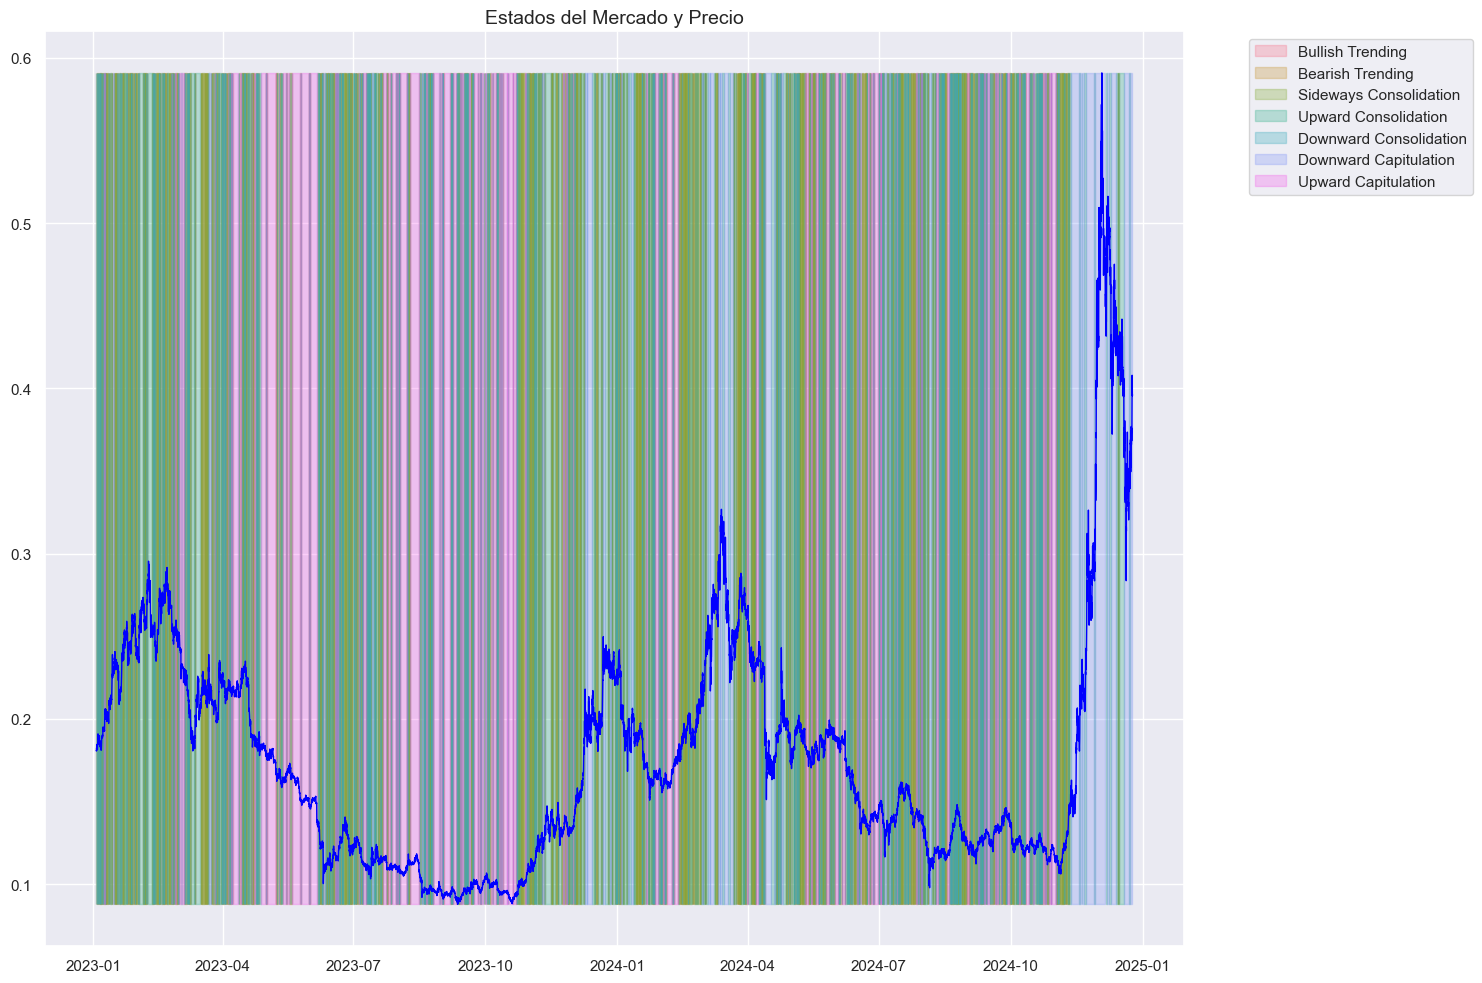

In [117]:
# Cell 4: Análisis visual
analyzer._plot_market_states()



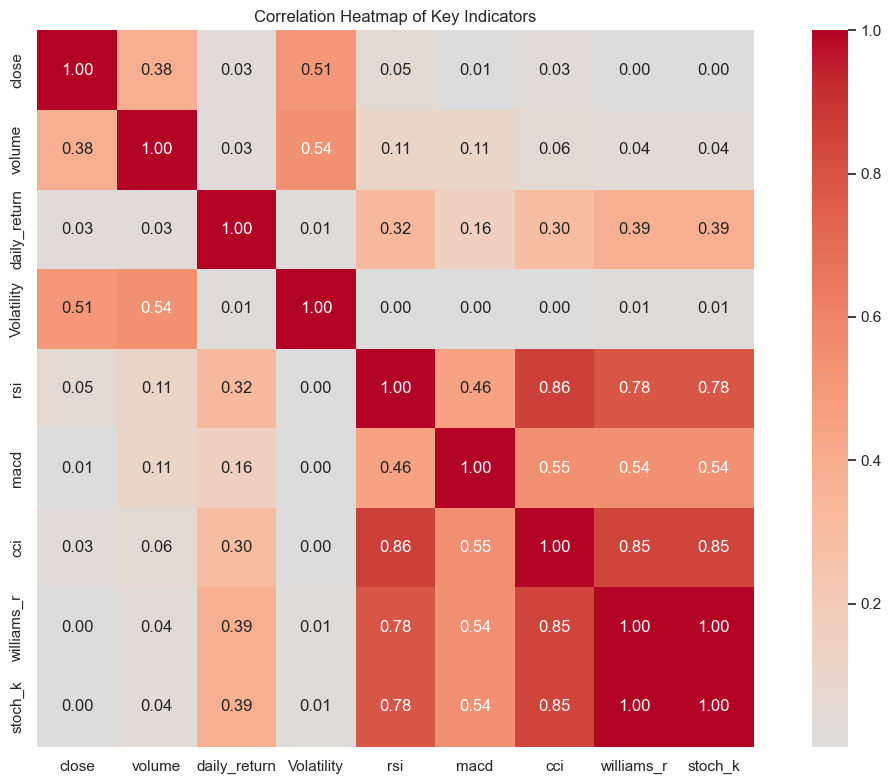


Insights de correlación:
- Strongest price correlation: Volatility (0.51)
- Strongest volume correlation: Volatility (0.54)
- RSI strongest correlation: cci (0.86)
- MACD strongest correlation: cci (0.55)
- CCI strongest correlation: rsi (0.86)


In [119]:
# Cell 6: Análisis de correlaciones
corr_analysis = analyzer.analyze_correlations_and_patterns()
print("\nInsights de correlación:")
for insight in corr_analysis.get('correlation_summary', []):
    print("-", insight)



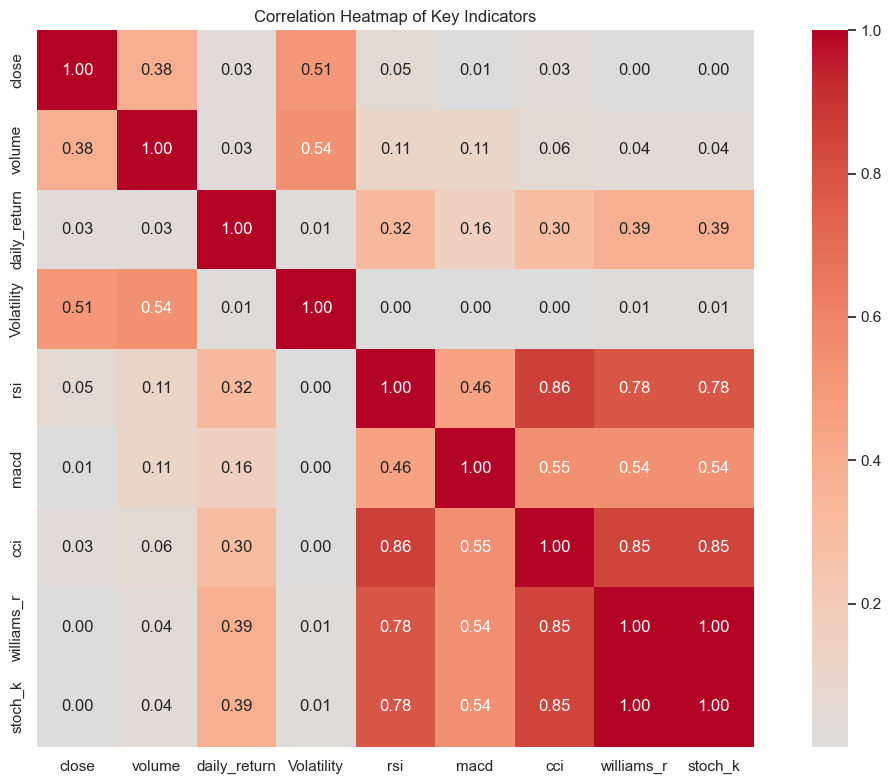


Reporte completo:
{
  "market_regime": {
    "current_state": "Downward Capitulation",
    "state_duration": 1655,
    "transition_probabilities": {
      "Bullish Trending": 0.000688646419577514,
      "Bearish Trending": 6.745961899443366e-110,
      "Sideways Consolidation": 0.0007189849709602034,
      "Upward Consolidation": 0.02037901809061183,
      "Downward Consolidation": 5.396978034600092e-123,
      "Downward Capitulation": 0.9782133505188505,
      "Upward Capitulation": 3.6584525282878485e-181
    },
    "market_conditions": {
      "trend_strength": 0.04788530211868535,
      "current_volatility": 0.018666264268112003,
      "rsi": 61.63924339245577,
      "volume_trend": "decreasing"
    },
    "state_stability": {
      "dominant_recent_state": "Downward Capitulation",
      "state_changes_frequency": 0.05
    }
  },
  "risk_metrics": {
    "value_at_risk_95": -0.014136811621171157,
    "conditional_var_95": -0.021086165428961395,
    "annual_volatility": 0.1390662925

In [120]:
# Cell 7: Reporte final
report = analyzer.generate_market_report()
print("\nReporte completo:")
print(json.dumps(report, indent=2))



C:\Users\pedro\AppData\Local\Temp\ipykernel_62696\2199247403.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
C:\Users\pedro\AppData\Local\Temp\ipykernel_62696\2199247403.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
C:\Users\pedro\AppData\Local\Temp\ipykernel_62696\2199247403.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')



Transition Probabilities:
                        Low Volatility/Ranging  Uptrend/Momentum  \
Low Volatility/Ranging              0.73073231        0.20284039   
Uptrend/Momentum                    0.07396846        0.90807047   
High Volatility                     0.05302092        0.00000000   

                        High Volatility  
Low Volatility/Ranging       0.06642730  
Uptrend/Momentum             0.01796107  
High Volatility              0.94697908  

Current State Analysis:
{'state': 'Uptrend/Momentum', 'strategy': {'type': 'trend_following', 'position_size': 'larger', 'stop_loss': 'wider', 'take_profit': 'trailing'}, 'duration': 7374, 'state_changes_frequency': 0.1}


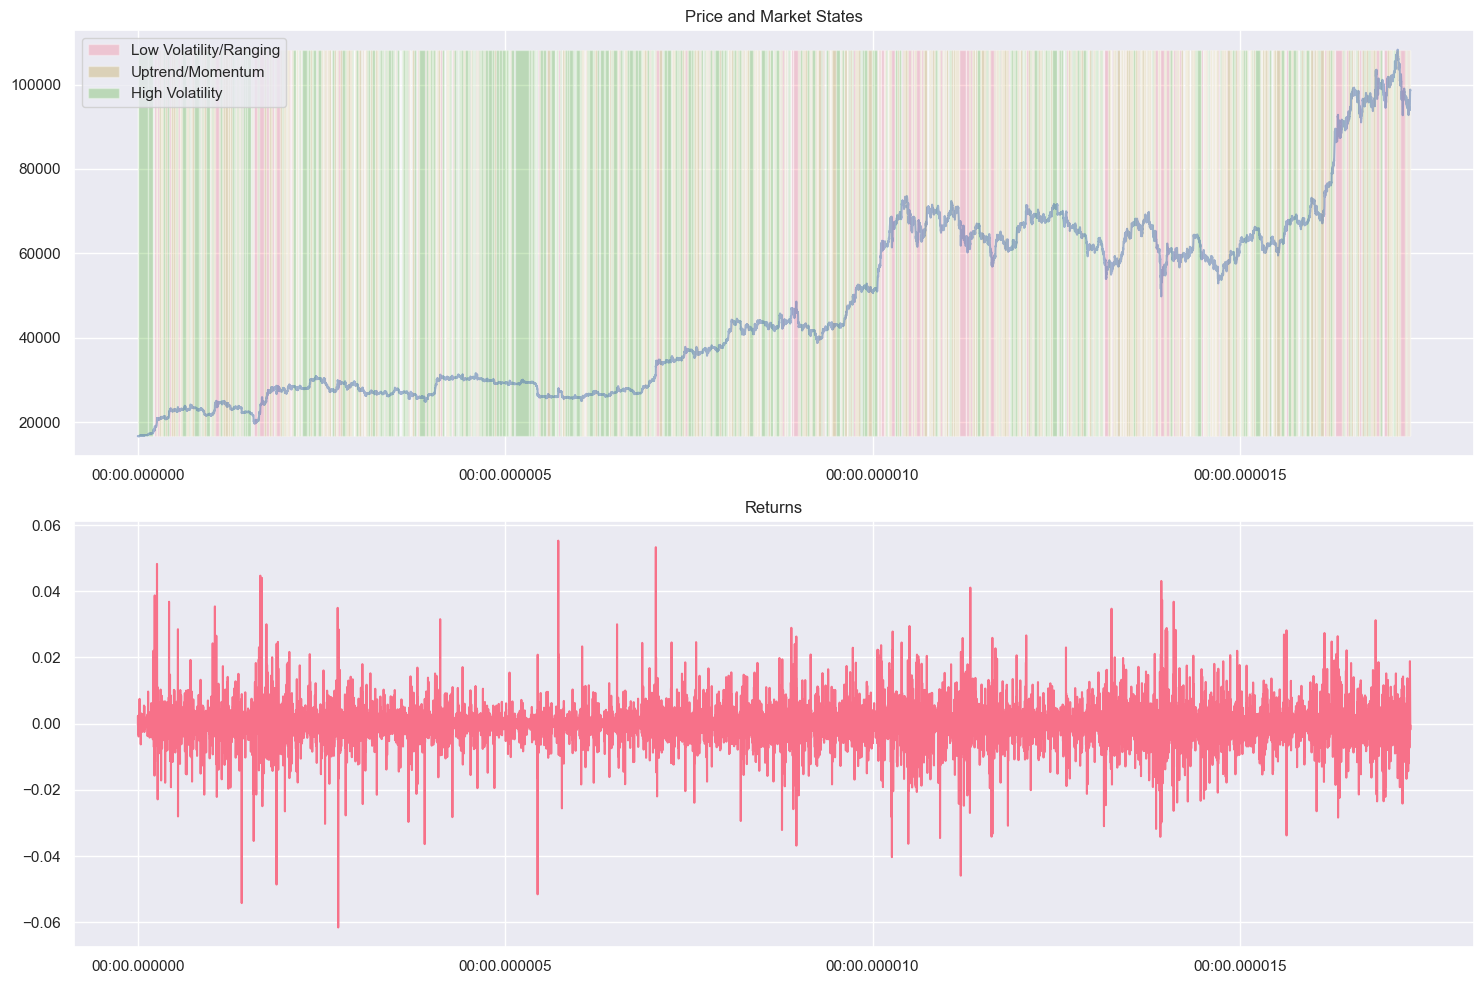

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import ta
import logging
from typing import Dict, List, Optional
from dataclasses import dataclass, field

@dataclass
class ModelConfig:
   n_components: int = 3
   covariance_type: str = "full" 
   n_iter: int = 1000
   random_state: int = 42
   volatility_window: int = 24
   
   state_names: Dict[int, str] = field(default_factory=lambda: {
       0: "Low Volatility/Ranging",
       1: "Uptrend/Momentum",
       2: "High Volatility"
   })
   
   features: List[str] = field(default_factory=lambda: [
       'Returns',
       'Volatility', 
       'Volume_Change'
   ])

   def get_state_strategy(self, state: int) -> Dict:
       strategies = {
           0: {
               'type': 'scalping',
               'position_size': 'base',
               'stop_loss': 'tight',
               'take_profit': 'small'
           },
           1: {
               'type': 'trend_following', 
               'position_size': 'larger',
               'stop_loss': 'wider',
               'take_profit': 'trailing'
           },
           2: {
               'type': 'defensive',
               'position_size': 'reduced',
               'stop_loss': 'very_tight',
               'take_profit': 'quick'
           }
       }
       return strategies[state]

class CryptoStateAnalyzer:
   def __init__(self, csv_path: str):
       self.config = ModelConfig()
       self.df = self._load_data(csv_path)
       self.model = None
       self.scaler = None
       self.states = None
       
   def _load_data(self, csv_path: str) -> pd.DataFrame:
        try:
            df = pd.read_csv(csv_path, sep=';', decimal='.')
            df['timestamp'] = pd.to_datetime(df.index)
            df.set_index('timestamp', inplace=True)
            
            df['Returns'] = df['close'].pct_change()
            df['Volatility'] = df['Returns'].rolling(window=self.config.volatility_window).std()
            df['Volume_Change'] = df['volume'].pct_change()
            
            # Handle infinities and NaNs
            for col in self.config.features:
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
                
                # Clip outliers
                Q1 = df[col].quantile(0.01)
                Q3 = df[col].quantile(0.99)
                IQR = Q3 - Q1
                df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
                
            return df.dropna()
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

   def train_model(self):
       X = self.df[self.config.features].values
       self.scaler = StandardScaler()
       X_scaled = self.scaler.fit_transform(X)
       
       self.model = hmm.GaussianHMM(
           n_components=self.config.n_components,
           covariance_type=self.config.covariance_type,
           n_iter=self.config.n_iter,
           random_state=self.config.random_state
       )
       
       self.model.fit(X_scaled)
       self.states = self.model.predict(X_scaled)
       
   def plot_states(self):
       fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
       
       # Price and states
       ax1.plot(self.df.index, self.df['close'], 'b-', alpha=0.5)
       ax1.set_title('Price and Market States')
       
       # Color states
       for state in range(self.config.n_components):
           mask = self.states == state
           ax1.fill_between(
               self.df.index, self.df['close'].min(), self.df['close'].max(),
               where=mask, alpha=0.3, label=self.config.state_names[state]
           )
       ax1.legend()
       
       # Returns
       ax2.plot(self.df.index, self.df['Returns'])
       ax2.set_title('Returns')
       
       plt.tight_layout()
       plt.show()
       
   def get_transition_probs(self):
       return pd.DataFrame(
           self.model.transmat_,
           index=self.config.state_names.values(),
           columns=self.config.state_names.values()
       )
   
   def get_current_state(self) -> Dict:
       if self.states is None:
           return {}
           
       current_state = self.states[-1]
       recent_states = self.states[-20:]
       
       return {
           'state': self.config.state_names[current_state],
           'strategy': self.config.get_state_strategy(current_state),
           'duration': len(self.states[self.states == current_state]),
           'state_changes_frequency': len(np.unique(recent_states)) / len(recent_states)
       }

# Usage example
if __name__ == "__main__":
   analyzer = CryptoStateAnalyzer('BTCUSDT_1h_2years.csv')
   analyzer.train_model()
   
   print("\nTransition Probabilities:")
   print(analyzer.get_transition_probs())
   
   print("\nCurrent State Analysis:")
   print(analyzer.get_current_state())
   
   analyzer.plot_states()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import hilbert
from scipy.stats import pearsonr
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from hmmlearn import hmm
import ta
import logging
from datetime import datetime, timedelta
import time
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Union
import warnings
import json
import pickle
from collections import deque
from binance.client import Client

warnings.filterwarnings('ignore')

# Configuration Classes
@dataclass
class MetricsConfig:
    lookback_window: int = 100
    phase_coherence_threshold: float = 0.7
    magnitude_threshold: float = 0.6
    tendency_threshold: float = 0.65
    volatility_window: int = 20
    classification_threshold: float = 0.5
    regression_metrics_window: int = 50
    classification_metrics_window: int = 50
    model_type: str = "hybrid"  # "regression", "classification", or "hybrid"

@dataclass
class RiskConfig:
    initial_balance: float = 1000.0
    base_risk_per_trade: float = 0.02
    max_positions: int = 3
    max_drawdown: float = 0.15
    consecutive_losses_limit: int = 3
    var_confidence_level: float = 0.99
    cvar_confidence_level: float = 0.975
    atr_multiplier: float = 2.0
    profit_lock_threshold: float = 0.3
    dynamic_position_scaling: bool = True
    volatility_scaling_enabled: bool = True
    correlation_threshold: float = 0.7
    max_exposure_per_asset: float = 0.25
    risk_reduction_rate: float = 0.1
    recovery_threshold: float = 0.05

@dataclass
class ModelConfig:
    n_components: int = 5
    covariance_type: str = "tied"
    n_iter: int = 2000
    random_state: int = 42
    lookback_window: int = 48
    feature_window: int = 24
    volatility_window: int = 24
    train_window: int = 720
    retrain_frequency: int = 168
    confidence_threshold: float = 0.75
    
    lstm_units: int = 50
    lstm_layers: int = 2
    dropout_rate: float = 0.2
    batch_size: int = 32
    epochs: int = 100
    
    features: List[str] = field(default_factory=lambda: [
        'Returns', 'Log_Returns', 'Volatility', 'Volume_Change',
        'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist',
        'BB_Width', 'BB_Position', 'ATR_Ratio',
        'Stoch_K', 'Stoch_D', 'ADX', 'DMI_Plus', 'DMI_Minus',
        'Higher_TF_Trend', 'Support_Resistance_Position',
        'Volume_Profile_Position', 'OBV_Change',
        'Fear_Greed_Index', 'Funding_Rate',
        'Price_Level_Density', 'Trade_Flow_Imbalance'
    ])


In [ ]:

# Enhanced Metrics Analyzer Class
class EnhancedMetricsAnalyzer:
    def __init__(self, config: MetricsConfig):
        self.config = config
        self.metrics_history = []
        self.regression_metrics = deque(maxlen=config.regression_metrics_window)
        self.classification_metrics = deque(maxlen=config.classification_metrics_window)
        
    def calculate_regression_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """
        Calculate comprehensive regression metrics
        """
        try:
            # Mean metrics
            mse = np.mean((y_true - y_pred) ** 2)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(y_true - y_pred))
            
            # Percentage metrics
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            
            # Direction accuracy
            direction_correct = np.sum(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))
            direction_accuracy = direction_correct / (len(y_true) - 1)
            
            # R-squared
            r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
            
            # Theil's U statistics
            changes_actual = np.diff(y_true)
            changes_pred = np.diff(y_pred)
            u1_num = np.sqrt(np.mean((changes_actual - changes_pred) ** 2))
            u1_den = np.sqrt(np.mean(changes_actual ** 2)) + np.sqrt(np.mean(changes_pred ** 2))
            theils_u = u1_num / u1_den if u1_den != 0 else 1
            
            return {
                'mse': mse,
                'rmse': rmse,
                'mae': mae,
                'mape': mape,
                'direction_accuracy': direction_accuracy,
                'r2': r2,
                'theils_u': theils_u
            }
        except Exception as e:
            print(f"Error calculating regression metrics: {str(e)}")
            return {}
            
    def calculate_classification_metrics(self, y_true: np.ndarray, y_pred: np.ndarray, 
                                      y_prob: Optional[np.ndarray] = None) -> Dict[str, float]:
        """
        Calculate comprehensive classification metrics
        """
        try:
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
            from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss
            
            # Basic classification metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='weighted')
            recall = recall_score(y_true, y_pred, average='weighted')
            f1 = f1_score(y_true, y_pred, average='weighted')
            
            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
            
            metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'true_negative': tn,
                'false_positive': fp,
                'false_negative': fn,
                'true_positive': tp
            }
            
            # Add probability-based metrics if probabilities are provided
            if y_prob is not None:
                # ROC AUC
                if y_prob.shape[1] == 2:  # Binary classification
                    auc = roc_auc_score(y_true, y_prob[:, 1])
                else:  # Multiclass
                    auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
                
                # Log loss
                loss = log_loss(y_true, y_prob)
                
                # Brier score (for binary classification)
                if y_prob.shape[1] == 2:
                    brier = np.mean((y_prob[:, 1] - y_true) ** 2)
                    metrics['brier_score'] = brier
                
                metrics.update({
                    'roc_auc': auc,
                    'log_loss': loss
                })
            
            return metrics
        except Exception as e:
            print(f"Error calculating classification metrics: {str(e)}")
            return {}
            
    def calculate_trading_specific_metrics(self, predictions: np.ndarray, 
                                        actual_returns: np.ndarray) -> Dict[str, float]:
        """
        Calculate trading-specific performance metrics
        """
        try:
            # Convert predictions to trading signals (-1, 0, 1)
            signals = np.sign(predictions)
            
            # Calculate strategy returns
            strategy_returns = signals[:-1] * actual_returns[1:]
            
            # Calculate metrics
            total_return = np.sum(strategy_returns)
            sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252) if np.std(strategy_returns) != 0 else 0
            
            # Calculate maximum drawdown
            cumulative_returns = np.cumsum(strategy_returns)
            rolling_max = np.maximum.accumulate(cumulative_returns)
            drawdowns = cumulative_returns - rolling_max
            max_drawdown = np.min(drawdowns)
            
            # Calculate win rate
            winning_trades = np.sum(strategy_returns > 0)
            total_trades = len(strategy_returns)
            win_rate = winning_trades / total_trades if total_trades > 0 else 0
            
            return {
                'total_return': total_return,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate,
                'total_trades': total_trades
            }
        except Exception as e:
            print(f"Error calculating trading metrics: {str(e)}")
            return {}
        
    def calculate_phase_coherence(self, series1: np.ndarray, series2: np.ndarray) -> float:
        try:
            analytic1 = hilbert(series1)
            analytic2 = hilbert(series2)
            phase1 = np.angle(analytic1)
            phase2 = np.angle(analytic2)
            phase_diff = phase1 - phase2
            coherence = np.abs(np.mean(np.exp(1j * phase_diff)))
            return coherence
        except Exception as e:
            print(f"Error calculating phase coherence: {str(e)}")
            return 0.0
            
    def calculate_magnitude_metrics(self, true_values: np.ndarray, pred_values: np.ndarray) -> Dict:
        try:
            true_envelope = np.abs(hilbert(true_values))
            pred_envelope = np.abs(hilbert(pred_values))
            envelope_corr, _ = pearsonr(true_envelope, pred_envelope)
            amp_diff = np.mean(np.abs(true_envelope - pred_envelope) / true_envelope)
            return {
                'envelope_correlation': envelope_corr,
                'amplitude_difference': amp_diff,
                'magnitude_score': max(0, (envelope_corr - amp_diff + 1) / 2)
            }
        except Exception as e:
            print(f"Error calculating magnitude metrics: {str(e)}")
            return {'envelope_correlation': 0, 'amplitude_difference': 1, 'magnitude_score': 0}
            
    def calculate_tendency_metrics(self, series: np.ndarray, window: int = 20) -> Dict:
        try:
            ma_short = pd.Series(series).rolling(window=window).mean()
            ma_long = pd.Series(series).rolling(window=window*2).mean()
            trend_strength = np.abs(ma_short - ma_long) / ma_long
            momentum = series - series.shift(window)
            return {
                'trend_strength': trend_strength.mean(),
                'momentum': momentum.mean(),
                'trend_consistency': np.sum(np.diff(series) > 0) / len(series)
            }
        except Exception as e:
            print(f"Error calculating tendency metrics: {str(e)}")
            return {'trend_strength': 0, 'momentum': 0, 'trend_consistency': 0}
    
    def calculate_shap_metrics(self, model, X: pd.DataFrame) -> Dict:
        try:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)
            
            if isinstance(shap_values, list):
                shap_values = shap_values[0]
            
            feature_importance = np.abs(shap_values).mean(0)
            top_features = np.argsort(feature_importance)[-3:]
            interaction_values = np.zeros((len(top_features), len(top_features)))
            
            for i, feat1 in enumerate(top_features):
                for j, feat2 in enumerate(top_features):
                    if i != j:
                        interaction_values[i,j] = np.abs(
                            shap.approximate_interactions(feat1, feat2, shap_values, X)
                        ).mean()
            
            return {
                'feature_importance': dict(zip(X.columns, feature_importance)),
                'top_interactions': interaction_values,
                'shap_scores': shap_values
            }
        except Exception as e:
            print(f"Error calculating SHAP metrics: {str(e)}")
            return {'feature_importance': {}, 'top_interactions': None, 'shap_scores': None}
            
    def plot_metrics_dashboard(self, metrics_dict: Dict):
        fig = plt.figure(figsize=(20, 12))
        
        ax1 = plt.subplot(231)
        sns.histplot(data=metrics_dict.get('phase_coherence_history', []), ax=ax1)
        ax1.axvline(self.config.phase_coherence_threshold, color='r', linestyle='--')
        ax1.set_title('Phase Coherence Distribution')
        
        ax2 = plt.subplot(232)
        magnitude_data = pd.DataFrame(metrics_dict.get('magnitude_history', []))
        sns.boxplot(data=magnitude_data, ax=ax2)
        ax2.set_title('Magnitude Metrics Distribution')
        
        ax3 = plt.subplot(233)
        tendency_data = pd.DataFrame(metrics_dict.get('tendency_history', []))
        sns.boxplot(data=tendency_data, ax=ax3)
        ax3.set_title('Tendency Metrics Distribution')
        
        if metrics_dict.get('shap_values') is not None:
            ax4 = plt.subplot(234)
            shap.summary_plot(metrics_dict['shap_values'], 
                            metrics_dict.get('feature_matrix'),
                            plot_type="bar", 
                            show=False,
                            ax=ax4)
            ax4.set_title('SHAP Feature Importance')
        
        ax5 = plt.subplot(235)
        metrics_df = pd.DataFrame(self.metrics_history)
        metrics_df[['phase_coherence', 'magnitude_score', 'trend_strength']].plot(ax=ax5)
        ax5.set_title('Metrics Time Series')
        
        plt.tight_layout()
        plt.show()
        
    def update_metrics(self, true_values: np.ndarray, pred_values: np.ndarray, 
                      model=None, features: pd.DataFrame = None) -> Dict:
        metrics = {}
        metrics['phase_coherence'] = self.calculate_phase_coherence(true_values, pred_values)
        magnitude_metrics = self.calculate_magnitude_metrics(true_values, pred_values)
        metrics.update(magnitude_metrics)
        tendency_metrics = self.calculate_tendency_metrics(true_values)
        metrics.update(tendency_metrics)
        
        if model is not None and features is not None:
            shap_metrics = self.calculate_shap_metrics(model, features)
            metrics.update(shap_metrics)
        
        self.metrics_history.append(metrics)
        return metrics



In [ ]:
# Hybrid Model Class
class HybridModel:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.hmm = hmm.GaussianHMM(
            n_components=config.n_components,
            covariance_type=config.covariance_type,
            n_iter=config.n_iter,
            random_state=config.random_state
        )
        self.lstm = self._build_lstm()
        self.scaler = StandardScaler()
        self.feature_scaler = StandardScaler()
        self.isolation_forest = IsolationForest(contamination=0.1)
        
    def _build_lstm(self):
        model = Sequential([
            LSTM(self.config.lstm_units, return_sequences=True,
                 input_shape=(self.config.lookback_window, len(self.config.features))),
            Dropout(self.config.dropout_rate),
            LSTM(self.config.lstm_units),
            Dropout(self.config.dropout_rate),
            Dense(3)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
        
    def prepare_sequence_data(self, features: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        X, y = [], []
        for i in range(len(features) - self.config.lookback_window):
            X.append(features[i:(i + self.config.lookback_window)])
            y.append(features[i + self.config.lookback_window])
        return np.array(X), np.array(y)
        
    def fit(self, features: np.ndarray):
        scaled_features = self.scaler.fit_transform(features)
        self.hmm.fit(scaled_features)
        X, y = self.prepare_sequence_data(scaled_features)
        if len(X) > 0:
            self.lstm.fit(X, y, 
                          batch_size=self.config.batch_size,
                          epochs=self.config.epochs,
                          verbose=0)
        self.isolation_forest.fit(scaled_features)
        
    def predict(self, features: np.ndarray) -> Dict[str, Union[int, float]]:
        scaled_features = self.scaler.transform(features)
        hmm_state = self.hmm.predict(scaled_features)[-1]
        hmm_proba = self.hmm.predict_proba(scaled_features)[-1]
        X = scaled_features[-self.config.lookback_window:].reshape(1, self.config.lookback_window, -1)
        lstm_pred = self.lstm.predict(X, verbose=0)[0]
        is_anomaly = self.isolation_forest.predict(scaled_features[-1].reshape(1, -1))[0] == -1
        
        return {
            'hmm_state': hmm_state,
            'hmm_confidence': hmm_proba[hmm_state],
            'lstm_direction': lstm_pred[0],
            'lstm_volatility': lstm_pred[1],
            'lstm_confidence': lstm_pred[2],
            'is_anomaly': is_anomaly
        }


In [ ]:

# Market Analyzer Class
class MarketAnalyzer:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = HybridModel(config)
        self.support_resistance_levels = []
        self.volume_profile = {}
        self.cached_signals = {}
        self.signal_history = deque(maxlen=100)
        
    def calculate_support_resistance(self, df: pd.DataFrame) -> List[float]:
        prices = df['close'].values.reshape(-1, 1)
        clustering = DBSCAN(eps=np.std(prices) * 0.1, min_samples=5)
        clusters = clustering.fit_predict(prices)
        
        levels = []
        for cluster in set(clusters):
            if cluster != -1:
                cluster_prices = prices[clusters == cluster]
                levels.append(float(np.mean(cluster_prices)))
        
        high, low = df['high'].max(), df['low'].min()
        fib_levels = [low + (high - low) * x for x in [0.236, 0.382, 0.5, 0.618, 0.786]]
        levels.extend(fib_levels)
        
        return sorted(set(levels))
        
    def calculate_volume_profile(self, df: pd.DataFrame, num_bins: int = 50) -> Dict[int, float]:
        price_range = df['high'].max() - df['low'].min()
        bin_size = price_range / num_bins
        
        volume_profile = {}
        for price, volume in zip(df['close'], df['volume']):
            bin_idx = int((price - df['low'].min()) / bin_size)
            if bin_idx in volume_profile:
                volume_profile[bin_idx] += volume
            else:
                volume_profile[bin_idx] = volume
        return volume_profile
        
    def prepare_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        # Price features
        df['Returns'] = df['close'].pct_change()
        df['Log_Returns'] = np.log1p(df['Returns'])
        df['Volatility'] = df['Returns'].rolling(window=self.config.volatility_window).std()
        df['Volume_Change'] = df['volume'].pct_change()
        
        # Technical indicators
        df['RSI'] = ta.momentum.rsi(df['close'])
        macd = ta.trend.MACD(df['close'])
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Hist'] = macd.macd_diff()
        
        # Bollinger Bands
        bb = ta.volatility.BollingerBands(df['close'])
        df['BB_Width'] = (bb.bollinger_hband() - bb.bollinger_lband()) / bb.bollinger_mavg()
        df['BB_Position'] = (df['close'] - bb.bollinger_lband()) / (bb.bollinger_hband() - bb.bollinger_lband())
        
        # DMI
        df['DMI_Plus'] = ta.trend.dx_pos(df['high'], df['low'], df['close'])
        df['DMI_Minus'] = ta.trend.dx_neg(df['high'], df['low'], df['close'])
        
        # OBV and OBV_Change
        df['OBV'] = ta.volume.on_balance_volume(df['close'], df['volume'])
        df['OBV_Change'] = df['OBV'].pct_change()
        
        # Market structure
        self.support_resistance_levels = self.calculate_support_resistance(df)
        self.volume_profile = self.calculate_volume_profile(df)
        
        df['Price_Level_Density'] = df['close'].apply(self.calculate_level_density)
        df['Trade_Flow_Imbalance'] = self.calculate_trade_flow_imbalance(df)
        
        # Higher timeframe trend
        df['Higher_TF_Trend'] = self.calculate_higher_timeframe_trend(df)
        
        return df
        
    def calculate_level_density(self, price: float) -> float:
        if not self.support_resistance_levels:
            return 0.0
        
        distances = [abs(price - level) for level in self.support_resistance_levels]
        density = sum(1 / (1 + d) for d in distances)
        return density / len(self.support_resistance_levels)
        
    def calculate_trade_flow_imbalance(self, df: pd.DataFrame) -> pd.Series:
        buy_volume = df['volume'] * (df['close'] > df['open']).astype(float)
        sell_volume = df['volume'] * (df['close'] <= df['open']).astype(float)
        return (buy_volume - sell_volume) / (buy_volume + sell_volume)
        
    def calculate_higher_timeframe_trend(self, df: pd.DataFrame) -> pd.Series:
        sma20 = df['close'].rolling(20).mean()
        sma50 = df['close'].rolling(50).mean()
        sma200 = df['close'].rolling(200).mean()
        
        trend = (
            0.5 * np.sign(sma20 - sma50) +
            0.3 * np.sign(sma50 - sma200) +
            0.2 * np.sign(sma20 - sma200)
        )
        return trend
        
    def analyze_market_condition(self, df: pd.DataFrame) -> Dict:
        features = self.prepare_features(df)
        predictions = self.model.predict(features[self.config.features].values)
        
        recent_volatility = features['Volatility'].iloc[-10:].mean()
        recent_volume = features['Volume_Change'].iloc[-10:].mean()
        
        market_condition = {
            'state': predictions['hmm_state'],
            'trend_confidence': predictions['hmm_confidence'],
            'predicted_direction': predictions['lstm_direction'],
            'predicted_volatility': predictions['lstm_volatility'],
            'model_confidence': predictions['lstm_confidence'],
            'is_anomaly': predictions['is_anomaly'],
            'current_volatility': recent_volatility,
            'volume_profile': recent_volume,
            'support_resistance': self.support_resistance_levels,
            'risk_score': self.calculate_risk_score(features)
        }
        
        self.signal_history.append(market_condition)
        return market_condition
        
    def calculate_risk_score(self, df: pd.DataFrame) -> float:
        latest = df.iloc[-1]
        
        volatility_risk = latest['Volatility'] / df['Volatility'].mean() if df['Volatility'].mean() != 0 else 0
        trend_risk = 1 - abs(latest['Higher_TF_Trend']) if not pd.isna(latest['Higher_TF_Trend']) else 1
        level_risk = latest['Price_Level_Density'] if not pd.isna(latest['Price_Level_Density']) else 0
        volume_risk = abs(latest['Volume_Change']) if not pd.isna(latest['Volume_Change']) else 0
        
        risk_score = (
            0.4 * volatility_risk +
            0.3 * trend_risk +
            0.2 * level_risk +
            0.1 * volume_risk
        )
        
        return min(max(risk_score, 0), 1)


In [ ]:

# Trading Strategy Class
class TradingStrategy:
    def __init__(self,
                 analyzer: MarketAnalyzer,
                 risk_config: RiskConfig,
                 initial_balance: float):
        self.analyzer = analyzer
        self.risk_config = risk_config
        self.balance = initial_balance
        self.peak_balance = initial_balance
        self.positions: Dict[int, Dict] = {}
        self.trades_history: List[Dict] = []
        self.current_drawdown = 0.0
        self.consecutive_losses = 0
        self.setup_logging()
        
    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            filename=f'trading_log_{datetime.now().strftime("%Y%m%d")}.txt'
        )
        self.logger = logging.getLogger(__name__)
        
    def calculate_position_size(self, price: float, market_condition: Dict) -> float:
        base_size = self.balance * self.risk_config.base_risk_per_trade
        
        condition_multiplier = 1.0
        if market_condition['is_anomaly']:
            condition_multiplier *= 0.5
        if (market_condition['current_volatility'] is not None and 
            market_condition['predicted_volatility'] is not None and
            market_condition['predicted_volatility'] != 0 and
            market_condition['current_volatility'] > 2 * market_condition['predicted_volatility']):
            condition_multiplier *= 0.7
            
        if self.current_drawdown > 0:
            condition_multiplier *= (1 - self.current_drawdown)
            
        confidence_multiplier = market_condition['model_confidence']
        if confidence_multiplier < self.analyzer.config.confidence_threshold:
            confidence_multiplier = 0
            
        volatility_scaling = 1.0
        if self.risk_config.volatility_scaling_enabled and \
           (market_condition['predicted_volatility'] is not None and 
            market_condition['predicted_volatility'] != 0):
            current_vol = market_condition['current_volatility']
            vol_ratio = current_vol / market_condition['predicted_volatility']
            volatility_scaling = 1.0 / (1.0 + np.log1p(vol_ratio))
            
        if self.consecutive_losses > 0:
            loss_scaling = (1 - self.risk_config.risk_reduction_rate) ** self.consecutive_losses
            condition_multiplier *= loss_scaling
            
        final_size = base_size * condition_multiplier * confidence_multiplier * volatility_scaling
        return min(final_size, self.balance * self.risk_config.max_exposure_per_asset)
        
    def calculate_stop_loss(self, price: float, market_condition: Dict) -> float:
        if (market_condition['current_volatility'] is None) or np.isnan(market_condition['current_volatility']):
            atr = 0.01 * price
        else:
            atr = market_condition['current_volatility'] * price
        
        atr_multiplier = self.risk_config.atr_multiplier * 0.5 if market_condition['is_anomaly'] else self.risk_config.atr_multiplier
        stop_distance = atr * atr_multiplier
        
        nearby_supports = [
            level for level in market_condition['support_resistance']
            if level < price and (price - level) / price < 0.02
        ]
        
        if nearby_supports:
            support_based_stop = max(nearby_supports) * 0.995
            return max(price - stop_distance, support_based_stop)
        
        return price - stop_distance
        
    def calculate_take_profit(self, entry_price: float, stop_loss: float, market_condition: Dict) -> float:
        risk = entry_price - stop_loss
        
        if market_condition['trend_confidence'] > 0.8:
            reward_ratio = 3.0
        elif market_condition['trend_confidence'] > 0.6:
            reward_ratio = 2.5
        else:
            reward_ratio = 2.0
            
        return entry_price + (risk * reward_ratio)
        
    def execute_trade(self, price: float, market_condition: Dict) -> bool:
        if len(self.positions) >= self.risk_config.max_positions:
            return False
            
        if market_condition['is_anomaly']:
            self.logger.warning("Anomaly detected - skipping trade")
            return False
            
        position_size = self.calculate_position_size(price, market_condition)
        if position_size == 0:
            return False
            
        stop_loss = self.calculate_stop_loss(price, market_condition)
        take_profit = self.calculate_take_profit(price, stop_loss, market_condition)
        
        position_id = len(self.trades_history)
        self.positions[position_id] = {
            'entry_price': price,
            'size': position_size,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'market_condition': market_condition,
            'entry_time': datetime.now(),
            'updated_time': datetime.now()
        }
        
        self.balance -= position_size
        self.logger.info(f"Entered position {position_id}: Price={price:.2f}, Size={position_size:.2f}")
        return True
        
    def update_positions(self, current_price: float, market_condition: Dict):
        for pos_id, position in list(self.positions.items()):
            if current_price > position['entry_price']:
                profit_pct = (current_price - position['entry_price']) / position['entry_price']
                if profit_pct > 0.02:
                    new_stop = self.calculate_stop_loss(current_price, market_condition)
                    position['stop_loss'] = max(position['stop_loss'], new_stop)
                    
            time_in_trade = (datetime.now() - position['entry_time']).total_seconds()
            should_exit = (
                current_price <= position['stop_loss'] or
                current_price >= position['take_profit'] or
                time_in_trade > 24 * 3600
            )
            
            if should_exit:
                self.exit_position(pos_id, current_price)
                
    def exit_position(self, position_id: int, exit_price: float):
        position = self.positions[position_id]
        pnl = (exit_price - position['entry_price']) * position['size']
        self.balance += position['size'] + pnl
        
        self.peak_balance = max(self.peak_balance, self.balance)
        self.current_drawdown = (self.peak_balance - self.balance) / self.peak_balance if self.peak_balance > 0 else 0
        
        if pnl > 0:
            self.consecutive_losses = 0
        else:
            self.consecutive_losses += 1
            
        trade_record = {
            'entry_price': position['entry_price'],
            'exit_price': exit_price,
            'size': position['size'],
            'pnl': pnl,
            'duration': (datetime.now() - position['entry_time']).total_seconds(),
            'market_condition': position['market_condition']
        }
        self.trades_history.append(trade_record)
        
        del self.positions[position_id]
        self.logger.info(f"Exited position {position_id}: PnL={pnl:.2f}")
        
    def get_performance_metrics(self) -> Dict:
        if not self.trades_history:
            return {}
            
        profits = [trade['pnl'] for trade in self.trades_history]
        returns = [trade['pnl'] / trade['size'] for trade in self.trades_history if trade['size'] != 0]
        
        positive_profits = [p for p in profits if p > 0]
        negative_profits = [p for p in profits if p < 0]
        
        total_profit = sum(profits)
        total_trades = len(profits)
        if total_trades == 0:
            return {}
        
        win_trades = len(positive_profits)
        win_rate = win_trades / total_trades if total_trades > 0 else 0.0
        
        profit_factor = float('inf') if not negative_profits else abs(sum(positive_profits) / sum(negative_profits))
        
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(365) if np.std(returns) != 0 else 0.0
        
        metrics = {
            'total_trades': total_trades,
            'profitable_trades': win_trades,
            'win_rate': win_rate,
            'total_profit': total_profit,
            'average_profit': np.mean(profits),
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': self.current_drawdown,
            'consecutive_losses': self.consecutive_losses,
            'current_balance': self.balance
        }
        
        return metrics


In [ ]:

# Main Trading System Class
class CryptoTradingSystem:
    def __init__(self,
                 api_key: str,
                 api_secret: str,
                 risk_config: RiskConfig,
                 model_config: ModelConfig):
        self.client = Client(api_key, api_secret)
        self.risk_config = risk_config
        self.model_config = model_config
        self.analyzer = MarketAnalyzer(model_config)
        self.strategy = TradingStrategy(self.analyzer, risk_config, risk_config.initial_balance)
        self.last_analysis_time: Optional[datetime] = None
        self.setup_logging()
        
    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            filename=f'system_log_{datetime.now().strftime("%Y%m%d")}.txt'
        )
        self.logger = logging.getLogger(__name__)
        
    def fetch_current_data(self) -> pd.DataFrame:
        klines = self.client.get_historical_klines(
            "BTCUSDT",
            Client.KLINE_INTERVAL_1HOUR,
            str(int((datetime.now() - timedelta(days=30)).timestamp() * 1000))
        )
        
        df = pd.DataFrame(klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_volume', 'trades', 'taker_buy_base',
            'taker_buy_quote', 'ignore'
        ])
        
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        
        numeric_cols = ['open', 'high', 'low', 'close', 'volume', 
                       'quote_volume', 'taker_buy_base', 'taker_buy_quote']
        df[numeric_cols] = df[numeric_cols].astype(float)
        
        return df
        
    def run(self):
        self.logger.info("Starting trading system...")
        
        while True:
            try:
                current_time = datetime.now()
                
                if (not self.last_analysis_time or 
                    (current_time - self.last_analysis_time).total_seconds() > 3600):
                    
                    df = self.fetch_current_data()
                    market_condition = self.analyzer.analyze_market_condition(df)
                    
                    current_price = float(df['close'].iloc[-1])
                    self.strategy.update_positions(current_price, market_condition)
                    
                    if self.strategy.balance > 0:
                        self.strategy.execute_trade(current_price, market_condition)
                    
                    metrics = self.strategy.get_performance_metrics()
                    self.logger.info(f"Performance metrics: {json.dumps(metrics, indent=2)}")
                    
                    self.last_analysis_time = current_time
                
                time.sleep(60)
                
            except Exception as e:
                self.logger.error(f"Error in main loop: {str(e)}")
                time.sleep(60)
                
    def save_state(self, filepath: str):
        state = {
            'analyzer_state': self.analyzer.__dict__,
            'strategy_state': self.strategy.__dict__,
            'last_analysis_time': self.last_analysis_time
        }
        with open(filepath, 'wb') as f:
            pickle.dump(state, f)
            
    def load_state(self, filepath: str):
        with open(filepath, 'rb') as f:
            state = pickle.load(f)
        self.analyzer.__dict__.update(state['analyzer_state'])
        self.strategy.__dict__.update(state['strategy_state'])
        self.last_analysis_time = state['last_analysis_time']



In [ ]:
# Example usage
if __name__ == "__main__":
    # Initialize configurations
    risk_config = RiskConfig()
    model_config = ModelConfig()
    
    # Create trading system instance
    system = CryptoTradingSystem(
        api_key="your_api_key",
        api_secret="your_api_secret",
        risk_config=risk_config,
        model_config=model_config
    )
    
    try:
        # Run the trading system
        system.run()
    except KeyboardInterrupt:
        # Save system state on exit
        system.save_state('trading_system_state.pkl')
        print("System state saved. Shutting down...")

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class FeatureAnalyzer:
    def __init__(self, csv_path):
        """Initialize with data from CSV file"""
        self.df = pd.read_csv(csv_path, sep=';', decimal='.', parse_dates=['timestamp'])
        self.df.set_index('timestamp', inplace=True)
        self.numeric_features = self.df.select_dtypes(include=[np.number]).columns

    def descriptive_analysis(self):
        """Comprehensive descriptive analysis of the dataset"""
        analysis = {
            'basic_info': {
                'total_rows': len(self.df),
                'total_columns': len(self.df.columns),
                'memory_usage': self.df.memory_usage().sum() / 1024**2,  # In MB
            },
            'missing_values': {
                'total_missing': self.df.isna().sum().sum(),
                'missing_by_column': self.df.isna().sum().to_dict(),
                'missing_percentage': (self.df.isna().sum() / len(self.df) * 100).to_dict()
            },
            'numeric_stats': self.df[self.numeric_features].describe().to_dict(),
            'data_types': self.df.dtypes.to_dict(),
            'unique_values': {col: self.df[col].nunique() for col in self.df.columns}
        }
        
        return analysis

    def feature_importance_analysis(self, target_col='close', k=10):
        """Analyze feature importance using multiple methods"""
        X = self.df[self.numeric_features].drop(columns=[target_col])
        y = self.df[target_col]
        
        # Handle missing values
        X = X.fillna(X.mean())
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        # Mutual Information
        mi_selector = SelectKBest(score_func=mutual_info_regression, k=k)
        mi_selector.fit(X_scaled, y)
        mi_scores = pd.DataFrame({
            'feature': X.columns,
            'mi_score': mi_selector.scores_
        }).sort_values('mi_score', ascending=False)
        
        # F-regression
        f_selector = SelectKBest(score_func=f_regression, k=k)
        f_selector.fit(X_scaled, y)
        f_scores = pd.DataFrame({
            'feature': X.columns,
            'f_score': f_selector.scores_
        }).sort_values('f_score', ascending=False)
        
        # Correlation analysis
        correlations = X.corrwith(pd.Series(y)).sort_values(ascending=False)
        
        return {
            'mutual_information': mi_scores,
            'f_regression': f_scores,
            'correlations': correlations
        }

    def plot_feature_distributions(self, columns=None):
        """Plot distributions of selected features"""
        if columns is None:
            columns = self.numeric_features[:10]  # Default to first 10 numeric features
            
        n_cols = 2
        n_rows = (len(columns) + 1) // 2
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        fig.suptitle('Feature Distributions', fontsize=16)
        
        for idx, col in enumerate(columns):
            row = idx // n_cols
            col_idx = idx % n_cols
            
            if n_rows == 1:
                ax = axes[col_idx]
            else:
                ax = axes[row, col_idx]
            
            sns.histplot(data=self.df, x=col, ax=ax, kde=True)
            ax.set_title(f'Distribution of {col}')
            
        plt.tight_layout()
        return fig

    def plot_correlation_matrix(self, n_features=15):
        """Plot correlation matrix for top features"""
        top_features = self.numeric_features[:n_features]
        corr_matrix = self.df[top_features].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Top Features')
        plt.tight_layout()
        
        return plt.gcf()

    def get_feature_recommendations(self, importance_results, threshold=0.1):
        """Get recommendations for feature selection"""
        recommendations = {
            'highly_important': [],
            'moderately_important': [],
            'less_important': []
        }
        
        # Normalize scores
        mi_scores = importance_results['mutual_information']
        mi_scores['mi_score_norm'] = (mi_scores['mi_score'] - mi_scores['mi_score'].min()) / \
                                   (mi_scores['mi_score'].max() - mi_scores['mi_score'].min())
        
        for _, row in mi_scores.iterrows():
            if row['mi_score_norm'] > 0.7:
                recommendations['highly_important'].append(row['feature'])
            elif row['mi_score_norm'] > 0.3:
                recommendations['moderately_important'].append(row['feature'])
            else:
                recommendations['less_important'].append(row['feature'])
                
        return recommendations

    def perform_pca(self, n_components=0.95):
        """
        Perform PCA analysis and export results
        
        Args:
            n_components: If float, represents the variance ratio to preserve
                         If int, represents the number of components to keep
        """
        # Prepare data
        X = self.df[self.numeric_features].fillna(0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Perform PCA
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(X_scaled)
        
        # Create component names
        component_names = [f'PC{i+1}' for i in range(pca_result.shape[1])]
        
        # Create DataFrame with PCA results
        pca_df = pd.DataFrame(
            data=pca_result,
            columns=component_names,
            index=self.df.index
        )
        
        # Create explained variance ratio DataFrame
        explained_variance_df = pd.DataFrame({
            'Component': component_names,
            'ExplainedVarianceRatio': pca.explained_variance_ratio_,
            'CumulativeVariance': np.cumsum(pca.explained_variance_ratio_)
        })
        
        # Create component loadings DataFrame
        loadings_df = pd.DataFrame(
            pca.components_.T,
            columns=component_names,
            index=self.numeric_features
        )
        
        # Export results
        pca_df.to_csv('pca_transformed_data.csv')
        explained_variance_df.to_csv('pca_explained_variance.csv')
        loadings_df.to_csv('pca_feature_loadings.csv')
        
        return {
            'transformed_data': pca_df,
            'explained_variance': explained_variance_df,
            'feature_loadings': loadings_df,
            'pca_object': pca
        }

    def calculate_fpi(self, target_col='close'):
        """
        Calculate Feature Importance Index using multiple methods
        """
        X = self.df[self.numeric_features].drop(columns=[target_col])
        y = self.df[target_col]
        
        # Handle missing values
        X = X.fillna(X.mean())
        
        # 1. Random Forest Importance
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        rf_importance = pd.DataFrame({
            'feature': X.columns,
            'rf_importance': rf.feature_importances_
        })
        
        # 2. Correlation Importance
        corr_importance = pd.DataFrame({
            'feature': X.columns,
            'correlation': X.corrwith(pd.Series(y)).abs()
        })
        
        # 3. Mutual Information
        mi = mutual_info_regression(X, y)
        mi_importance = pd.DataFrame({
            'feature': X.columns,
            'mutual_info': mi
        })
        
        # Combine all methods
        fpi_df = pd.DataFrame({'feature': X.columns})
        fpi_df = fpi_df.merge(rf_importance, on='feature')
        fpi_df = fpi_df.merge(corr_importance, on='feature')
        fpi_df = fpi_df.merge(mi_importance, on='feature')
        
        # Normalize scores
        for col in ['rf_importance', 'correlation', 'mutual_info']:
            fpi_df[f'{col}_norm'] = (fpi_df[col] - fpi_df[col].min()) / \
                                   (fpi_df[col].max() - fpi_df[col].min())
        
        # Calculate FPI
        fpi_df['FPI'] = fpi_df[[col for col in fpi_df.columns if '_norm' in col]].mean(axis=1)
        
        # Sort by FPI
        fpi_df = fpi_df.sort_values('FPI', ascending=False)
        
        # Export results
        fpi_df.to_csv('feature_importance_index.csv')
        
        return fpi_df

    def export_all_analyses(self, target_col='close'):
        """
        Perform and export all analyses
        """
        # 1. Descriptive Analysis
        desc_analysis = self.descriptive_analysis()
        pd.DataFrame(desc_analysis['missing_values']['missing_percentage'].items(),
                    columns=['Feature', 'MissingPercentage']).to_csv('missing_values_analysis.csv')
        pd.DataFrame(desc_analysis['numeric_stats']).to_csv('numeric_statistics.csv')
        
        # 2. Feature Importance Analysis
        importance_results = self.feature_importance_analysis(target_col=target_col)
        importance_results['mutual_information'].to_csv('mutual_information_scores.csv')
        importance_results['f_regression'].to_csv('f_regression_scores.csv')
        pd.DataFrame(importance_results['correlations']).to_csv('feature_correlations.csv')
        
        # 3. PCA Analysis
        pca_results = self.perform_pca()
        
        # 4. FPI Analysis
        fpi_results = self.calculate_fpi(target_col=target_col)
        
        # 5. Outlier Analysis
        outlier_stats = self.analyze_outliers()
        pd.DataFrame(outlier_stats).T.to_csv('outlier_analysis.csv')
        
        return {
            'descriptive': desc_analysis,
            'importance': importance_results,
            'pca': pca_results,
            'fpi': fpi_results,
            'outliers': outlier_stats
        }

    def analyze_outliers(self):
        """Analyze outliers in numeric features"""
        outlier_stats = {}
        
        for col in self.numeric_features:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)][col]
            
            outlier_stats[col] = {
                'total_outliers': len(outliers),
                'percentage_outliers': (len(outliers) / len(self.df)) * 100,
                'min': outliers.min() if not outliers.empty else None,
                'max': outliers.max() if not outliers.empty else None
            }
            
        return outlier_stats

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the analyzer
analyzer = FeatureAnalyzer('ALGOUSDT_1h_2years.csv')

# 1. Perform PCA Analysis
print("\n=== PCA Analysis ===")
pca_results = analyzer.perform_pca(n_components=0.95)
print("\nExplained Variance by Components:")
print(pca_results['explained_variance'])



=== PCA Analysis ===

Explained Variance by Components:
  Component  ExplainedVarianceRatio  CumulativeVariance
0       PC1                0.422373            0.422373
1       PC2                0.202539            0.624912
2       PC3                0.108915            0.733827
3       PC4                0.053018            0.786846
4       PC5                0.048411            0.835257
5       PC6                0.039745            0.875002
6       PC7                0.031759            0.906761
7       PC8                0.025707            0.932468
8       PC9                0.017231            0.949699
9      PC10                0.010592            0.960290


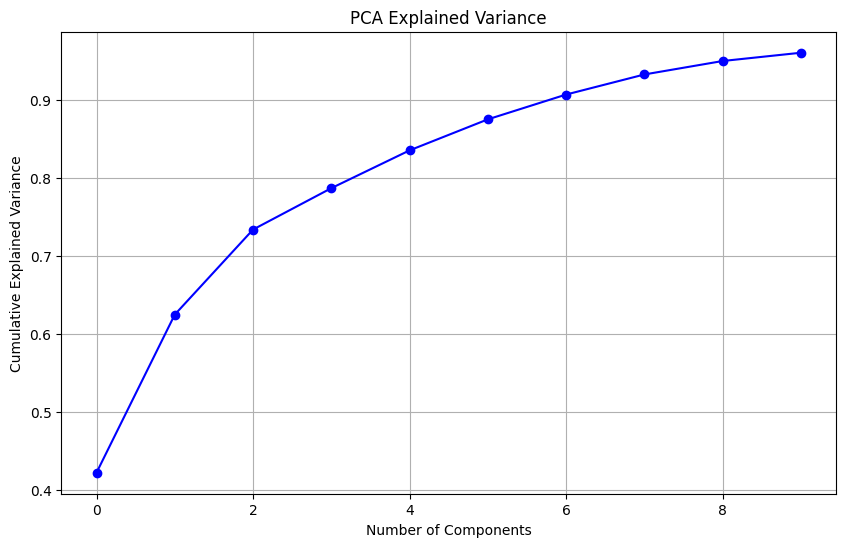

In [6]:

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(pca_results['explained_variance']['CumulativeVariance'], 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()




=== Feature Importance Index ===

Top 10 Features by FPI:
              feature       FPI
37  cumulative_return  1.000000
1                high  0.527401
2                 low  0.522902
0                open  0.497662
13             ema_20  0.466438
24     bollinger_high  0.461679
10             sma_20  0.459837
26      bollinger_mid  0.459824
25      bollinger_low  0.457026
11             sma_50  0.444362


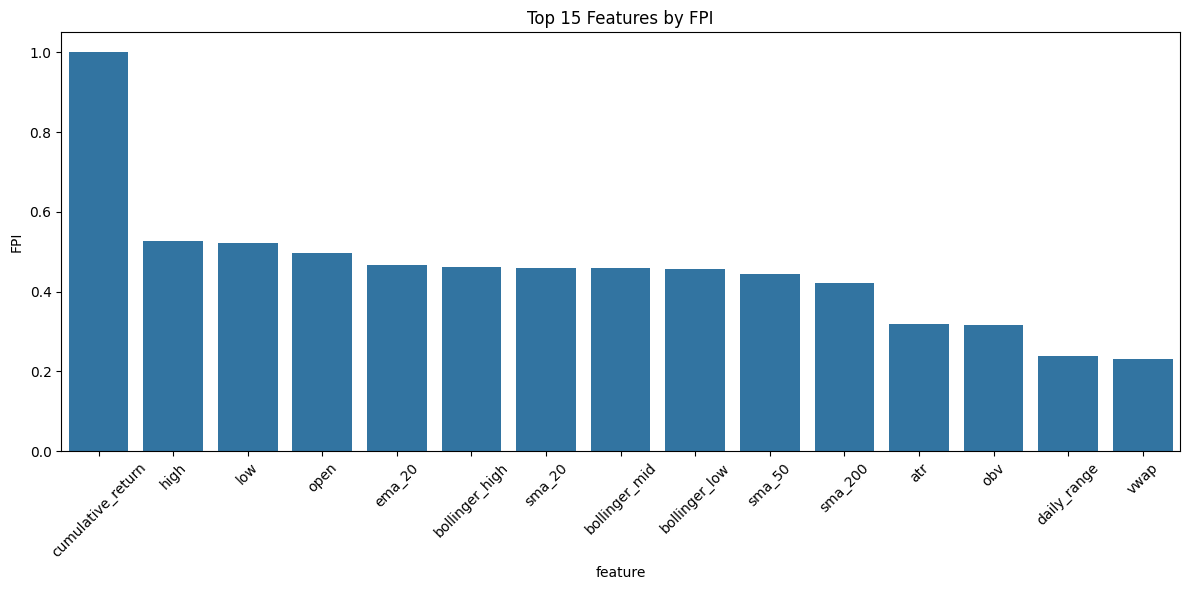

In [7]:
# 2. Calculate Feature Importance Index
print("\n=== Feature Importance Index ===")
fpi_results = analyzer.calculate_fpi()
print("\nTop 10 Features by FPI:")
print(fpi_results[['feature', 'FPI']].head(10))

# Plot FPI results
plt.figure(figsize=(12, 6))
sns.barplot(data=fpi_results.head(15), x='feature', y='FPI')
plt.xticks(rotation=45)
plt.title('Top 15 Features by FPI')
plt.tight_layout()
plt.show()


In [ ]:

# 3. Export all analyses
print("\n=== Exporting All Analyses ===")
all_results = analyzer.export_all_analyses()

print("\nFiles exported:")
print("- PCA Analysis:")
print("  * pca_transformed_data.csv")
print("  * pca_explained_variance.csv")
print("  * pca_feature_loadings.csv")
print("\n- Feature Importance:")
print("  * feature_importance_index.csv")
print("  * mutual_information_scores.csv")
print("  * f_regression_scores.csv")
print("  * feature_correlations.csv")
print("\n- Other Analyses:")
print("  * missing_values_analysis.csv")
print("  * numeric_statistics.csv")
print("  * outlier_analysis.csv")

In [4]:
from binance.client import Client
import pandas as pd
from binance.enums import *
import math
from datetime import datetime

class BinanceTradeManager:
    def __init__(self, api_key: str, api_secret: str):
        try:
            self.client = Client(api_key, api_secret)
        except Exception as e:
            print(f"Error initializing client: {str(e)}")
            raise

    def get_spot_portfolio(self) -> pd.DataFrame:
        """Get spot portfolio with USDT values and 24h changes"""
        try:
            account_info = self.client.get_account()
            balances = []
            
            for asset in account_info['balances']:
                free = float(asset['free'])
                locked = float(asset['locked'])
                total = free + locked
                
                if total > 0:
                    if asset['asset'] == 'USDT':
                        usdt_value = total
                        price_change = 0
                    else:
                        try:
                            ticker = self.client.get_ticker(symbol=f"{asset['asset']}USDT")
                            current_price = float(ticker['lastPrice'])
                            usdt_value = total * current_price
                            price_change = float(ticker['priceChangePercent'])
                        except:
                            usdt_value = 0
                            price_change = 0
                            
                    balances.append({
                        'Asset': asset['asset'],
                        'Free': round(free, 8),
                        'Locked': round(locked, 8),
                        'Total': round(total, 8),
                        'USDT Value': round(usdt_value, 2),
                        '24h Change %': round(price_change, 2)
                    })
            
            df = pd.DataFrame(balances)
            df = df.sort_values('USDT Value', ascending=False)
            
            total_value = df['USDT Value'].sum()
            print(f"\nTotal Spot Portfolio Value: {round(total_value, 2)} USDT")
            print(f"Last Updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            
            return df
        
        except Exception as e:
            print(f"Error getting spot portfolio: {str(e)}")
            return pd.DataFrame()
    
    def get_futures_portfolio(self) -> pd.DataFrame:
        """Get futures portfolio positions and balances"""
        try:
            # Get futures account information
            account = self.client.futures_account()
            
            # Get positions
            positions = []
            for position in account['positions']:
                amt = float(position['positionAmt'])
                if amt != 0:  # Only get active positions
                    positions.append({
                        'Symbol': position['symbol'],
                        'Side': 'LONG' if amt > 0 else 'SHORT',
                        'Size': abs(amt),
                        'Entry Price': float(position['entryPrice']),
                        'Mark Price': float(position['markPrice']),
                        'PnL': float(position['unrealizedProfit']),
                        'Margin Type': position['marginType']
                    })
            
            # Get balances
            balances = []
            for asset in account['assets']:
                if float(asset['walletBalance']) > 0:
                    balances.append({
                        'Asset': asset['asset'],
                        'Wallet Balance': float(asset['walletBalance']),
                        'Unrealized PnL': float(asset['unrealizedProfit']),
                        'Margin Balance': float(asset['marginBalance'])
                    })
            
            # Create DataFrames
            positions_df = pd.DataFrame(positions)
            balances_df = pd.DataFrame(balances)
            
            print("\nFutures Positions:")
            if not positions_df.empty:
                print(positions_df.to_string(index=False))
            else:
                print("No open positions")
                
            print("\nFutures Balances:")
            print(balances_df.to_string(index=False))
            
            return positions_df, balances_df
            
        except Exception as e:
            print(f"Error getting futures portfolio: {str(e)}")
            return pd.DataFrame(), pd.DataFrame()

    def execute_order(self, symbol: str, side: str, amount: float, market_type: str = 'spot', amount_is_quantity: bool = False) -> dict:
        """
        Execute a market order in spot or futures
        Parameters:
            symbol: Trading pair (e.g., 'ALGOUSDT')
            side: 'BUY' or 'SELL'
            amount: Amount in USDT or quantity
            market_type: 'spot' or 'futures'
            amount_is_quantity: True if amount is quantity, False if amount is USDT
        """
        try:
            if market_type.lower() == 'spot':
                order_params = {
                    'symbol': symbol,
                    'side': side,
                    'type': ORDER_TYPE_MARKET
                }
                
                if amount_is_quantity:
                    info = self.client.get_symbol_info(symbol)
                    lot_size = float(next(filter(lambda x: x['filterType'] == 'LOT_SIZE', info['filters']))['stepSize'])
                    quantity = math.floor(amount / lot_size) * lot_size
                    order_params['quantity'] = '{:.8f}'.format(quantity).rstrip('0').rstrip('.')
                else:
                    order_params['quoteOrderQty'] = amount
                    
                order = self.client.create_order(**order_params)
                
            elif market_type.lower() == 'futures':
                order_params = {
                    'symbol': symbol,
                    'side': side,
                    'type': 'MARKET'
                }
                
                if amount_is_quantity:
                    order_params['quantity'] = '{:.8f}'.format(amount).rstrip('0').rstrip('.')
                else:
                    # Convert USDT amount to quantity for futures
                    price = float(self.client.futures_symbol_ticker(symbol=symbol)['price'])
                    quantity = amount / price
                    order_params['quantity'] = '{:.8f}'.format(quantity).rstrip('0').rstrip('.')
                
                order = self.client.futures_create_order(**order_params)
            
            else:
                raise ValueError("market_type must be either 'spot' or 'futures'")
            
            # Print order details
            print(f"\nOrder executed successfully in {market_type}:")
            if 'executedQty' in order and 'cummulativeQuoteQty' in order:
                print(f"Executed Quantity: {order['executedQty']} {symbol.replace('USDT', '')}")
                print(f"Total Value: {float(order['cummulativeQuoteQty']):.4f} USDT")
            else:
                print(order)
            
            return order
            
        except Exception as e:
            print(f"Error executing order: {str(e)}")
            return None

In [8]:
# Initialize the manager
api_key = 'ZuKrYEk1lC9ORNyYpOUowOMTQToH3C1Tqp3hM7zLKV2TkFXYFrawe2Jr0gbkx6O3'
api_secret = 'JKUjNlmPrEISyo88VzXSPJqEPI9zcuhaqU1yNxzvZEGWej2Zrx7Y3bDh3jZtLuqL'
manager = BinanceTradeManager(api_key, api_secret)

# View spot portfolio
print("SPOT PORTFOLIO:")
spot_portfolio = manager.get_spot_portfolio()
print(spot_portfolio.to_string(index=False))

# View futures portfolio
print("\nFUTURES PORTFOLIO:")
futures_positions, futures_balances = manager.get_futures_portfolio()



SPOT PORTFOLIO:

Total Spot Portfolio Value: 0.1 USDT
Last Updated: 2024-12-29 21:32:17

Asset       Free  Locked      Total  USDT Value  24h Change %
 BONK 3000.00000     0.0 3000.00000        0.09         -2.95
 USDT    0.00669     0.0    0.00669        0.01          0.00

FUTURES PORTFOLIO:

Futures Positions:
No open positions

Futures Balances:
Empty DataFrame
Columns: []
Index: []


In [ ]:
# Buy 10 USDT worth of ALGO in spot
print("\nBuying 10 USDT worth of ALGO in spot:")
spot_buy = manager.execute_order('ALGOUSDT', SIDE_BUY, 10, 'spot', False)

# Buy 10 USDT worth of ALGO in futures
print("\nBuying 10 USDT worth of ALGO in futures:")
futures_buy = manager.execute_order('ALGOUSDT', SIDE_BUY, 10, 'futures', False)

# Sell 2 ALGO in spot
print("\nSelling 2 ALGO in spot:")
spot_sell = manager.execute_order('ALGOUSDT', SIDE_SELL, 2, 'spot', True)

# Sell 2 ALGO in futures
print("\nSelling 2 ALGO in futures:")
futures_sell = manager.execute_order('ALGOUSDT', SIDE_SELL, 2, 'futures', True)

# View updated portfolios
print("\nUPDATED SPOT PORTFOLIO:")
updated_spot = manager.get_spot_portfolio()
print(updated_spot.to_string(index=False))

print("\nUPDATED FUTURES PORTFOLIO:")
updated_futures_positions, updated_futures_balances = manager.get_futures_portfolio()